# **RQ2: How do architectural models differ when generated through an interactive process?**

# **TRAIN TICKET Case Study**

The idea is to identify/look for architectural characteristics that appeared due to the user's choices (centroids).

Indicators:
*   Architectural objectives such as: *#changes* and *pas* (2D space). Univariate and bi-variate analyses. Types of clusters identified in the objective space.
*   Common (intersection) and different models in the search spaces. This can be assessed by looking at the sequences of (types of) refactoring actions used in each dataset.
  *   Shapes of search trees for refactoring actions (types only) and distances among trees.
  *   Frequency of (or most common) refactoring actions (types only) used in the architectures.




In [288]:
#!pip install altair --quiet
#!pip install pca --quiet
#!pip install zss --quiet
#!pip install pymoo --quiet 
##!pip install dataframe_image --quiet
#!pip install distinctipy --quiet
##!pip install fastDamerauLevenshtein --quiet
#!pip install opentsne --quiet
#!pip install yellowbrick --quiet
#!pip install plotly --quiet
#!pip install networkx --quiet
#!pip install matplotlib_venn --quiet

In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
#import dataframe_image as dfi
from PIL import Image
import networkx as nx
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout

In [290]:
# This is the class that imports all the functions needed for the analysis
from architecturespaceanalyzer import ArchitectureSpaceAnalyzer 

---

## **File downloads and Parsing**

In [291]:
# This is the reference Pareto front/space
NSGAII_PROJECT_NAME = 'nsgaii-train-ticket-1000-eval'
NSGAII_DATAPATH =  './zips/'+ NSGAII_PROJECT_NAME +'.zip' 

### *Non-interactive run*

In [292]:
# This is the non-interactive run (100 eval, length 4)
# ttbs-baseline-100-eval 
NSGAII_IT0_100_PROJECT_NAME = 'nsgaii-train-ticket-sbspe-100-eval-it-0'
NSGAII_IT0_100_DATAPATH = './zips/'+NSGAII_IT0_100_PROJECT_NAME +'.zip' 

### _Interactive runs_

In [293]:
# ttbs 1st step of 50 eval, length 2
NSGAII_IT0_50_PROJECT_NAME = 'nsgaii-train-ticket-sbspe-50-eval-it-0-l-2'
NSGAII_IT0_50_DATAPATH = './zips/'+NSGAII_IT0_50_PROJECT_NAME +'.zip' 

In [294]:
# ttbs 2nd step of 50 eval, length 2 (using centroid 258)
NSGAII_IT1_50_C258_PROJECT_NAME = 'nsgaii-train-ticket-sbspe-50-eval-it-1-l-2-centroid-258'
NSGAII_IT1_50_C258_DATAPATH = './zips/'+NSGAII_IT1_50_C258_PROJECT_NAME +'.zip' 

In [295]:
# ttbs 2nd step of 50 eval, length 2 (using centroid 223)
NSGAII_IT1_50_C223_PROJECT_NAME = 'nsgaii-train-ticket-sbspe-50-eval-it-1-l-2-centroid-223'
NSGAII_IT1_50_C223_DATAPATH = './zips/'+ NSGAII_IT1_50_C223_PROJECT_NAME +'.zip' 


In [296]:
%%capture
!unzip -o $NSGAII_DATAPATH -d datasets
!unzip -o $NSGAII_IT0_100_DATAPATH -d datasets
!unzip -o $NSGAII_IT0_50_DATAPATH -d datasets
!unzip -o $NSGAII_IT1_50_C258_DATAPATH -d datasets
!unzip -o $NSGAII_IT1_50_C223_DATAPATH -d datasets

In [297]:
#!rm -r 'datasets'

# **ANALYSIS OF ARCHITECTURAL MODELS**

In [298]:
# All possible labels for solutions (for all datasets)
ALL_CLUSTER_LABELS = ['- / - / very-few / very-few',
  '- / - / very-few / few',
  '- / - / very-few / average',
  '- / - / very-few / some',
  '- / - / very-few / many',
  '- / - / few / very-few',
  '- / - / few / few',
  '- / - / few / average',
  '- / - / few / some',
  '- / - / few / many',
  '- / - / average / very-few',
  '- / - / average / few',
  '- / - / average / average',
  '- / - / average / some',
  '- / - / average / many',
  '- / - / some / very-few',
  '- / - / some / few',
  '- / - / some / average',
  '- / - / some / some',
  '- / - / some / many',
  '- / - / many / very-few',
  '- / - / many / few',
  '- / - / many / average',
  '- / - / many / some',
  '- / - / many / many']

In [299]:
OBJS_CHANGES_PAS = ['#changes', 'pas'] # Only considering these 2 objectives
PROBLEM_OBJECTIVES = ['perfQ', 'reliability']+OBJS_CHANGES_PAS

# Global (common) ranges for the 2 objectives
CHANGES_LIMITS = (2.5,50)
PAS_LIMITS = (0,14)

In [300]:
def get_values_as_dataframe(countops, algo, budget):
  operations_index = [1,2,3,4]*4
  refactions_index = [item for sublist in countops[0] for item in sublist]
  refactions_frequencies = {(algo,budget): [item for sublist in countops[1] for item in sublist]}

  return operations_index, refactions_index, refactions_frequencies

In [301]:
def plot3(sets3, titles=['', '', ''], colors=['tab:red', 'tab:green', 'tab:blue'], ax=None, percentage=True):
  total = len(sets3[0].union(sets3[1], sets3[2]))
  print("Union of solutions:", total)
  if percentage:
    venn3(sets3, set_labels=tuple(titles), set_colors=tuple(colors), subset_label_formatter=lambda x: f"{(x/total):1.0%}", ax=ax)
  else:
    venn3(sets3, set_labels=tuple(titles), set_colors=tuple(colors), ax=ax)

def plot2(sets2, titles=['', ''], colors=['tab:red', 'tab:green'], ax=None, percentage=True):
  total = len(sets2[0].union(sets2[1]))
  print("Union of solutions:", total)
  if percentage:
    venn2(sets2, set_labels=tuple(titles), set_colors=tuple(colors), subset_label_formatter=lambda x: f"{(x/total):1.0%}", ax=ax)
  else:
    venn2(sets2, set_labels=tuple(titles), set_colors=tuple(colors), ax=ax)

---
## **Reference Pareto Front (1000)**

In [302]:
# Initialize the project/file
ref1000_space = ArchitectureSpaceAnalyzer(objectives=OBJS_CHANGES_PAS)
ref1000_space.initialize_dataset(NSGAII_PROJECT_NAME)
print(ref1000_space.PROJECT_NAME)

ref1000_space.set_labels(ALL_CLUSTER_LABELS)
ref1000_space.CHANGES_LIMITS = CHANGES_LIMITS
ref1000_space.PAS_LIMITS = PAS_LIMITS

# Read all the objectives and refactoring actions
# Note that length of sequences is 4
_ = ref1000_space.read_file_batch(1,31, length=4, arguments=0, option='all')

project: nsgaii-train-ticket-1000-eval
objective files= 31
refactoring actions files= 31
nsgaii-train-ticket-1000-eval
Reading files ... 1 31 all
  file 0
  file 1
  file 2
  file 3
  file 4
  file 5
  file 6
  file 7
  file 8
  file 9
  file 10
  file 11
  file 12
  file 13
  file 14
  file 15
  file 16
  file 17
  file 18
  file 19
  file 20
  file 21
  file 22
  file 23
  file 24
  file 25
  file 26
  file 27
  file 28
  file 29
  file 30
done.


In [303]:
# This the global palette for all cluster labels
sns.color_palette(ref1000_space.CLUSTERS_COLORS)

[(0.0, 1.0, 0.0),
 (1.0, 0.0, 1.0),
 (0.0, 0.5019607843137255, 1.0),
 (1.0, 0.5019607843137255, 0.0),
 (0.5019607843137255, 0.7490196078431373, 0.5019607843137255),
 (0.34509803921568627, 0.0, 0.6470588235294118),
 (0.7411764705882353, 0.00784313725490196, 0.047058823529411764),
 (0.2, 0.4980392156862745, 0.00784313725490196),
 (0.7411764705882353, 0.4745098039215686, 0.9921568627450981),
 (0.984313725490196, 0.9921568627450981, 0.25882352941176473),
 (0.0, 1.0, 1.0),
 (0.0, 1.0, 0.5019607843137255),
 (0.0, 0.5019607843137255, 0.5019607843137255),
 (0.7529411764705882, 0.25882352941176473, 0.5098039215686274),
 (0.0, 0.0, 1.0),
 (0.5372549019607843, 0.8627450980392157, 0.00784313725490196),
 (0.5294117647058824, 0.9607843137254902, 0.9764705882352941),
 (0.9333333333333333, 0.7058823529411765, 0.6274509803921569),
 (0.396078431372549, 0.4235294117647059, 0.7215686274509804),
 (0.2901960784313726, 0.19607843137254902, 0.21176470588235294),
 (0.5450980392156862, 0.13333333333333333, 0.996078431372549),
 (0.6392156862745098, 0.3607843137254902, 0.03137254901960784),
 (1.0, 0.0, 0.5019607843137255),
 (0.21568627450980393, 0.7215686274509804, 0.7725490196078432),
 (0.03529411764705882, 0.7215686274509804, 0.2235294117647059)]

In [304]:
ref1000_space.objectives_df.head()

solID     perfQ  reliability  #changes  pas
0    193  0.145989     0.872976      5.80  3.0
1    305  0.323642     0.811052      5.80  2.0
2  10436  0.311507     0.425184      6.18  0.0
3  27162  0.353116     0.432430     11.74  1.0
4  27194  0.311507     0.425184      6.18  0.0

Statistics for #changes and pas objectives

In [305]:
ref1000_space.objectives_df[OBJS_CHANGES_PAS].describe()

#changes         pas
count  495.000000  495.000000
mean     8.542727    1.595960
std      4.865854    1.279859
min      5.800000    0.000000
25%      5.990000    1.000000
50%      6.180000    1.000000
75%     11.740000    2.000000
max     48.450000   14.000000

In [306]:
#ref1000_space.refactions_df.head()

### *Metrics*

In [307]:
ref1000_pf = ref1000_space.get_pareto_front()
ref1000_norm_pf = ref1000_space.compute_pareto_front()

# Look only at some of the metrics (NPS, HV, DE)
metrics1000_dict = ref1000_space.compute_all_metrics(ref_point=(1,1), reference_front=ref1000_norm_pf)
metrics1000_dict['point'] = 'reference'
print("Pareto front metrics (#changes versus pas):")
print(metrics1000_dict)
print('\tNPS', metrics1000_dict['NPS'], 'solutions')
print('\tHV', metrics1000_dict['HV'])
print('\tDE', metrics1000_dict['DE'])

ref1000_pf.head()

Pareto front metrics (#changes versus pas):
{'C_AB': 1.0, 'C_BA': 1.0, 'IGDPlus': 0.0, 'HV': 0.9990453860324904, 'NPS': 24, 'NSolutions': 99, 'NSequences': 492, 'DE': 0.44029739333874585, 'point': 'reference'}
	NPS 24 solutions
	HV 0.9990453860324904
	DE 0.44029739333874585


#changes  pas
0      6.18  0.0
1      6.37  0.0
2      5.99  1.0
3      5.99  1.0
4      6.18  1.0

### *Clustering*

In [308]:
# Try k-Means
#labels, _, silhouette = ref1000_space.run_kmeans(k=5, show_silhouette=False) 

# Try agglomerative clustering
labels, _, silhouette = ref1000_space.run_agglomerative(k=5, threshold=None, show_dendogram=False) 
ref1000_space.assign_cluster_labels(labels) # This effectively assigns the labels

Number of clusters = 5
Labels for instances: [1 1 3 0 3 0 0 0 1 2 3 0 0 0 0 0 1 1 3 1 1 3 3 0 3 3 1 3 3 1 1 1 1 3 3 1 3
 1 1 3 3 1 1 1 3 3 3 1 1 1 2 3 0 3 0 0 0 0 3 0 3 3 1 1 1 1 0 2 0 1 2 3 1 2
 3 0 0 3 0 3 1 0 1 3 0 0 0 0 0 0 0 0 0 0 1 0 1 3 3 0 0 0 0 1 3 0 1 0 3 3 1
 1 1 3 3 0 0 0 0 0 1 0 0 0 0 3 0 1 1 3 0 3 0 0 0 0 1 0 1 1 1 3 1 3 1 0 3 1
 3 0 0 0 1 1 3 0 3 1 0 3 1 1 3 1 1 1 3 0 0 3 1 3 1 3 3 1 1 1 3 1 1 0 3 0 0
 1 1 1 3 3 1 3 1 3 3 0 0 3 0 1 1 0 1 3 3 3 3 3 1 1 3 0 0 1 0 0 2 3 1 0 1 3
 3 1 1 3 0 0 0 0 0 0 0 2 3 2 2 0 0 0 1 1 3 4 0 1 3 3 0 3 0 0 0 1 3 1 1 3 1
 1 3 3 1 1 1 3 1 3 3 1 3 3 1 1 0 3 0 0 1 0 1 3 0 3 3 1 3 1 3 1 1 3 3 3 1 1
 1 1 3 1 3 1 1 1 1 1 0 3 1 0 1 1 0 3 1 3 3 0 3 1 1 3 1 0 0 0 1 1 3 0 3 1 3
 3 0 1 1 1 0 3 1 1 3 3 3 3 3 3 1 1 3 1 1 3 1 1 1 1 0 0 1 3 3 3 1 1 1 1 1 1
 1 3 1 3 1 2 0 0 1 0 3 0 3 0 1 3 3 1 1 0 0 1 3 1 3 3 3 1 1 1 1 3 1 3 1 0 1
 0 1 1 1 1 1 1 1 1 1 0 3 3 0 1 3 0 0 0 3 1 1 1 3 3 1 1 3 0 1 0 1 0 3 0 1 0
 3 3 1 1 3 1 0 3 3 1 0 3 1 1 3 1 1 3 3 1 1 3 0 0 0 0 1 

perfQ  reliability  #changes   pas  cluster  \
116  0.364878     0.226731     13.73   1.0        0   
147  0.204506     0.872976      5.99   2.0        1   
70   0.198819     0.846598     15.26   5.0        2   
430  0.264760     0.658015      6.18   1.0        3   
243  0.205996     0.847111     48.45  14.0        4   

                           label  
116       - / - / few / very-few  
147  - / - / very-few / very-few  
70             - / - / few / few  
430  - / - / very-few / very-few  
243          - / - / many / many

In [309]:
# Graphical representations of objectives in 2D space
ref1000_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True)
#ref1000_space.show_petal_plot(labels=True, size=(20,5))

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [310]:
ref1000_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True, pfonly=True)

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [311]:
ref1000_space.clusters_info()

  cluster 1 : 191 items 38.59 % - / - / very-few / very-few
  cluster 3 : 159 items 32.12 % - / - / very-few / very-few
  cluster 0 : 134 items 27.07 % - / - / few / very-few
  cluster 2 : 10 items 2.02 % - / - / few / few
  cluster 4 : 1 items 0.20 % - / - / many / many


In [312]:
ref1000_space.describe_cluster_labels(objectives=OBJS_CHANGES_PAS)

Using predefined limits (0, 1.0)
Using predefined limits (2.5, 50)
Using predefined limits (0, 14)
Using predefined limits (0, 1.0)


objective    min    max  unit     label
5   #changes   2.40  11.94  unit  very-few
6   #changes  11.94  21.48  unit       few
7   #changes  21.48  31.02  unit   average
8   #changes  31.02  40.56  unit      some
9   #changes  40.56  50.10  unit      many
10       pas  -0.10   2.74  unit  very-few
11       pas   2.74   5.58  unit       few
12       pas   5.58   8.42  unit   average
13       pas   8.42  11.26  unit      some
14       pas  11.26  14.10  unit      many

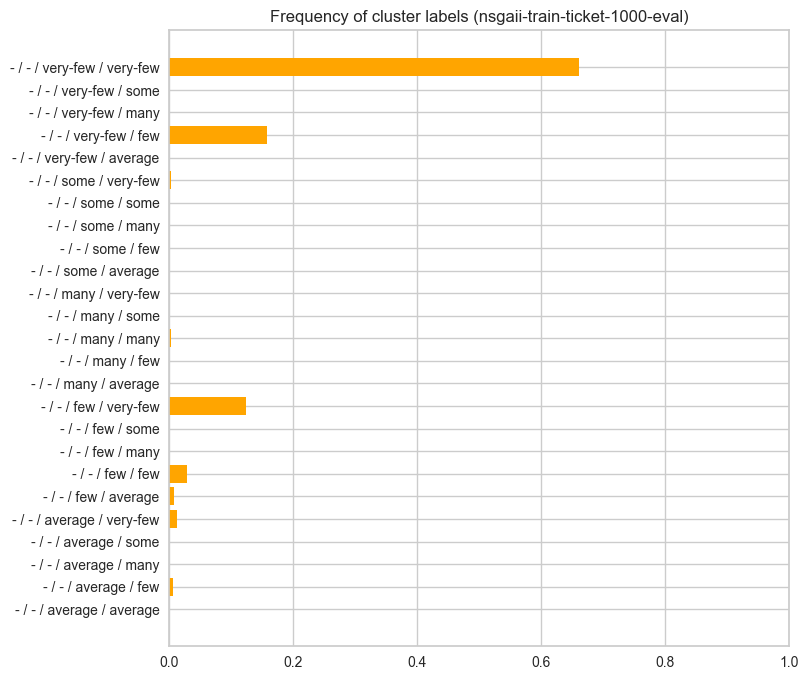

{'- / - / average / average': 0.0,
 '- / - / average / few': 0.006060606060606061,
 '- / - / average / many': 0.0,
 '- / - / average / some': 0.0,
 '- / - / average / very-few': 0.012121212121212121,
 '- / - / few / average': 0.00808080808080808,
 '- / - / few / few': 0.028282828282828285,
 '- / - / few / many': 0.0,
 '- / - / few / some': 0.0,
 '- / - / few / very-few': 0.12323232323232323,
 '- / - / many / average': 0.0,
 '- / - / many / few': 0.0,
 '- / - / many / many': 0.00202020202020202,
 '- / - / many / some': 0.0,
 '- / - / many / very-few': 0.0,
 '- / - / some / average': 0.0,
 '- / - / some / few': 0.0,
 '- / - / some / many': 0.0,
 '- / - / some / some': 0.0,
 '- / - / some / very-few': 0.00202020202020202,
 '- / - / very-few / average': 0.0,
 '- / - / very-few / few': 0.15757575757575756,
 '- / - / very-few / many': 0.0,
 '- / - / very-few / some': 0.0,
 '- / - / very-few / very-few': 0.6606060606060606}

In [313]:
ref1000_space.show_cluster_labels_distribution(size=(8,8))

### *Visualizations (density)*

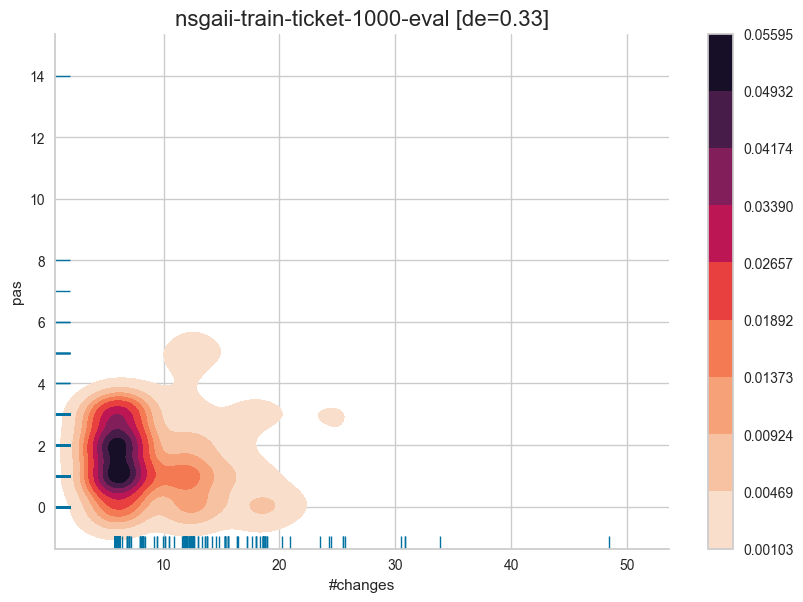

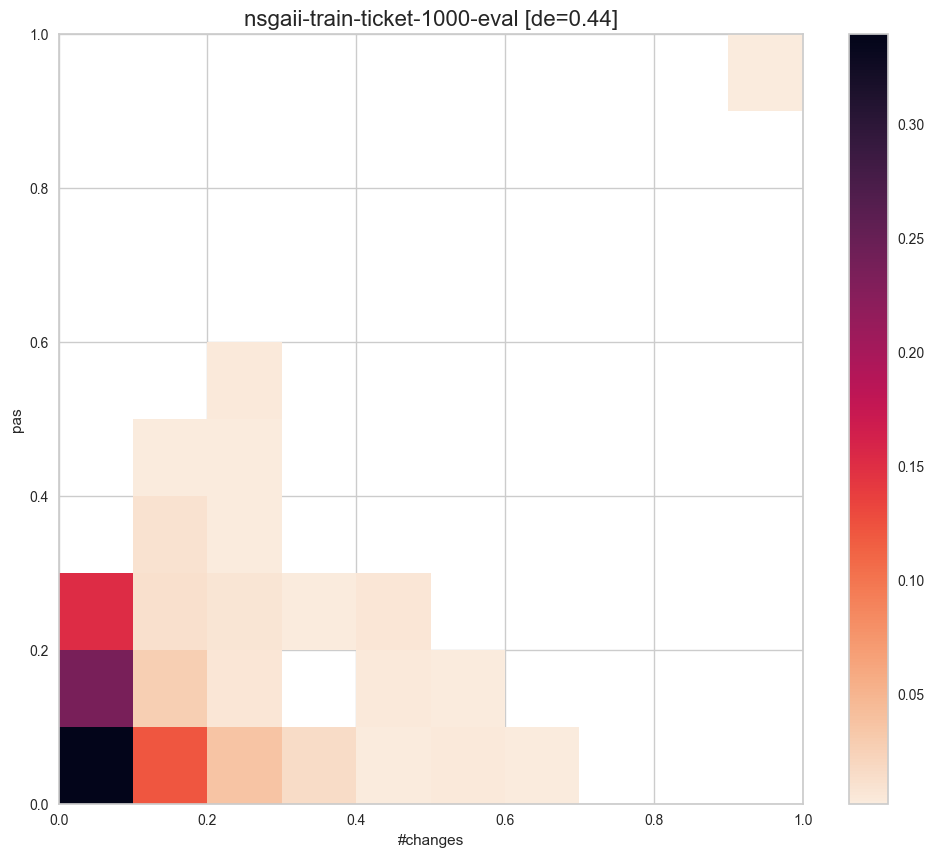

In [314]:
# Density plots for the 2D space of changes versus pas
ref1000_space.show_density_plot(objectives=OBJS_CHANGES_PAS, normalize=False) 
ref1000_space.show_density_plot(kind='bins', objectives=OBJS_CHANGES_PAS, normalize=True, bins=10)

In [315]:
# Entropy of 2D space
de_2D = ref1000_space.compute_density_entropy(normalize=True, bins=10)
print("The density entropy is:", de_2D)

The density entropy is: 0.44029739333874585


---
## **Iteration 0 (interactive, 50)**

In [316]:
# Initialize the project/file
it0_50_space = ArchitectureSpaceAnalyzer(objectives=OBJS_CHANGES_PAS)
it0_50_space.initialize_dataset(NSGAII_IT0_50_PROJECT_NAME)
print(it0_50_space.PROJECT_NAME)

it0_50_space.set_labels(ALL_CLUSTER_LABELS)
it0_50_space.CHANGES_LIMITS = CHANGES_LIMITS
it0_50_space.PAS_LIMITS = PAS_LIMITS

# Read all the objectives and refactoring actions
# Note that length of sequences is 2
_ = it0_50_space.read_file_batch(1,31, length=2, arguments=0, option='all')

project: nsgaii-train-ticket-sbspe-50-eval-it-0-l-2
objective files= 31
refactoring actions files= 31
nsgaii-train-ticket-sbspe-50-eval-it-0-l-2
Reading files ... 1 31 all
  file 0
  file 1
  file 2
  file 3
  file 4
  file 5
  file 6
  file 7
  file 8
  file 9
  file 10
  file 11
  file 12
  file 13
  file 14
  file 15
  file 16
  file 17
  file 18
  file 19
  file 20
  file 21
  file 22
  file 23
  file 24
  file 25
  file 26
  file 27
  file 28
  file 29
  file 30
done.


In [317]:
it0_50_space.objectives_df.head()

solID     perfQ  reliability  #changes  pas
0    419  0.210716     0.299766      3.28  0.0
1    921  0.153165     0.847111      2.90  2.0
2   1006  0.264819     0.709835      2.90  2.0
3    842  0.209112     0.663923      4.10  1.0
4    761  0.209150     0.726455      3.09  3.0

Statistics for #changes and pas objectives.

In [318]:
it0_50_space.objectives_df[OBJS_CHANGES_PAS].describe()

#changes         pas
count  496.000000  496.000000
mean     3.945887    1.435484
std      2.073667    0.972278
min      2.900000    0.000000
25%      2.900000    1.000000
50%      3.090000    1.000000
75%      3.280000    2.000000
max     13.920000    5.000000

In [319]:
#it0_50_space.refactions_df.head()

### *Metrics* - Not need to analyze them in this dataset

In [320]:
ref50_it0_pf = it0_50_space.get_pareto_front()
#ref50_it0_norm_pf = it0_50_space.compute_pareto_front(invert_max=True)

# The reference front is the ref1000 space
metrics50_it0_dict = it0_50_space.compute_all_metrics(ref_point=(1,1), reference_front=ref1000_norm_pf)
metrics50_it0_dict['point'] = 'it-0'
print("Pareto front metrics (#changes versus pas):")
print(metrics50_it0_dict)

ref50_it0_pf.head()

Pareto front metrics (#changes versus pas):
{'C_AB': 0.625, 'C_BA': 1.0, 'IGDPlus': 0.12031050063850032, 'HV': 0.9896551724137931, 'NPS': 7, 'NSolutions': 29, 'NSequences': 459, 'DE': 0.2987550413519693, 'point': 'it-0'}


#changes  pas
0      3.28  0.0
1      3.09  1.0
2      3.28  1.0
3      2.90  2.0
4      3.09  2.0

### *Clustering*
Only for the purpose of showing the centroids chosen for Iteration 1

In [321]:
# Try k-Means
#labels, _, silhouette = it1_50_c258_space.run_kmeans(k=5, show_silhouette=False) 

# Try agglomerative clustering
labels, _, silhouette = it0_50_space.run_agglomerative(k=5, threshold=None, show_dendogram=False) 
it0_50_space.assign_cluster_labels(labels) # This effectively assigns the labels

Number of clusters = 5
Labels for instances: [3 0 0 4 0 4 3 4 0 3 4 4 4 0 3 3 3 2 0 0 1 4 2 2 3 2 2 4 0 4 0 2 0 2 0 3 4
 2 1 4 0 4 2 2 3 0 0 4 0 0 0 3 3 0 4 2 3 2 4 4 0 3 0 4 0 0 3 0 0 3 0 3 4 4
 4 0 0 4 0 4 0 3 0 1 3 0 1 4 0 4 0 0 3 0 4 4 0 0 3 4 3 0 2 0 4 0 4 0 4 0 4
 4 0 3 2 0 2 4 0 2 4 2 4 2 4 0 4 0 2 0 3 0 1 2 3 0 2 2 4 2 2 0 3 4 2 0 0 3
 2 2 3 0 4 0 4 2 2 4 0 0 0 0 4 3 3 4 3 0 4 0 3 3 4 0 4 4 0 2 0 3 2 3 0 0 3
 4 0 4 4 0 0 4 0 0 3 3 0 4 4 4 4 0 0 0 0 4 4 0 0 2 0 2 4 0 3 4 2 4 0 4 0 0
 0 0 0 2 3 0 3 2 0 2 4 2 2 4 2 4 0 4 0 0 0 3 3 0 3 4 4 4 4 0 3 3 4 4 0 0 3
 3 4 0 2 4 0 4 0 0 3 3 3 4 0 0 3 3 2 3 3 0 2 4 4 4 0 4 4 0 0 2 3 3 0 2 4 0
 3 2 4 4 0 2 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 2 4 3 2 0 4 4 4 4
 3 4 0 0 3 0 4 2 0 0 3 2 2 4 0 0 0 4 0 0 0 3 2 0 2 0 3 2 4 4 0 0 4 0 4 3 0
 2 0 4 0 3 2 2 4 0 0 4 0 2 4 0 0 3 4 2 4 0 3 2 4 0 0 4 4 0 4 0 0 3 2 3 2 0
 4 1 3 2 4 3 2 2 0 0 0 2 3 0 2 4 3 4 0 4 0 2 4 3 4 0 0 2 4 0 3 2 0 3 4 0 4
 0 4 3 0 0 3 4 0 4 3 0 4 0 4 3 0 4 0 0 0 0 0 3 4 0 3 4 

perfQ  reliability  #changes  pas  cluster  \
351  0.205996     0.784135      2.90  2.0        0   
38   0.205996     0.788695      8.04  4.0        1   
102  0.209824     0.665843      8.61  1.0        2   
9    0.195684     0.599092      3.28  0.0        3   
87   0.183605     0.587942      3.09  1.0        4   

                           label  
351  - / - / very-few / very-few  
38        - / - / very-few / few  
102  - / - / very-few / very-few  
9    - / - / very-few / very-few  
87   - / - / very-few / very-few

In [322]:
#it0_50_space.show_petal_plot(labels=True, size=(20,5))

This is the **first centroid (258)** chosen as a decision point for the next rounds of search.



In [323]:
centroid_series = it0_50_space.tagged_objectives_df.loc[258]
print(centroid_series)
centroid_rows = it0_50_space.tagged_objectives_df[it0_50_space.tagged_objectives_df['solID']==1334]
centroid_rows

perfQ                             0.208608
reliability                       0.302645
#changes                              3.28
pas                                    0.0
cluster                                  3
label          - / - / very-few / very-few
solID                                 1334
Name: 258, dtype: object


perfQ  reliability  #changes  pas  cluster  \
258  0.208608     0.302645      3.28  0.0        3   

                           label  solID  
258  - / - / very-few / very-few   1334

This is the **second centroid (223)** chosen as a decision point for the next rounds of search.

In [324]:
centroid_series = it0_50_space.tagged_objectives_df.loc[223]
print(centroid_series)
centroid_rows = it0_50_space.tagged_objectives_df[it0_50_space.tagged_objectives_df['solID']==584]
centroid_rows

perfQ                             0.205996
reliability                       0.788695
#changes                               2.9
pas                                    2.0
cluster                                  0
label          - / - / very-few / very-few
solID                                  584
Name: 223, dtype: object


perfQ  reliability  #changes  pas  cluster  \
223  0.205996     0.788695       2.9  2.0        0   

                           label  solID  
223  - / - / very-few / very-few    584

**Note that both centroids have more or less the same architectural characteristics with respect to #changes and pas. However, they differ in their tradeoffs with respect to performance and reliability.**

In [325]:
it0_50_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True)

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [326]:
it0_50_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True, pfonly=True)

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [327]:
it0_50_space.clusters_info()

  cluster 0 : 198 items 39.92 % - / - / very-few / very-few
  cluster 4 : 133 items 26.81 % - / - / very-few / very-few
  cluster 3 : 88 items 17.74 % - / - / very-few / very-few
  cluster 2 : 71 items 14.31 % - / - / very-few / very-few
  cluster 1 : 6 items 1.21 % - / - / very-few / few


In [328]:
it0_50_space.describe_cluster_labels(objectives=OBJS_CHANGES_PAS)

Using predefined limits (0, 1.0)
Using predefined limits (2.5, 50)
Using predefined limits (0, 14)
Using predefined limits (0, 1.0)


objective    min    max  unit     label
5   #changes   2.40  11.94  unit  very-few
6   #changes  11.94  21.48  unit       few
7   #changes  21.48  31.02  unit   average
8   #changes  31.02  40.56  unit      some
9   #changes  40.56  50.10  unit      many
10       pas  -0.10   2.74  unit  very-few
11       pas   2.74   5.58  unit       few
12       pas   5.58   8.42  unit   average
13       pas   8.42  11.26  unit      some
14       pas  11.26  14.10  unit      many

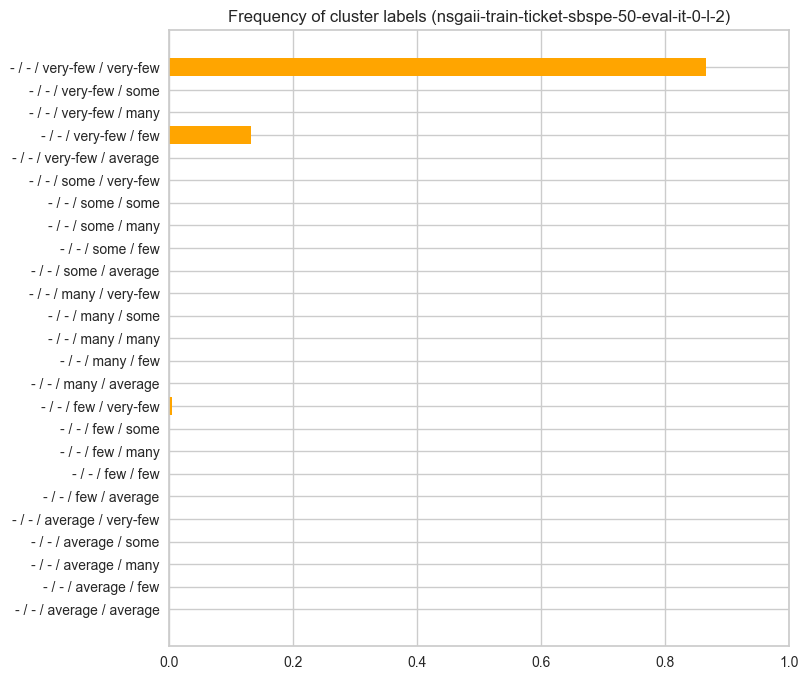

{'- / - / average / average': 0.0,
 '- / - / average / few': 0.0,
 '- / - / average / many': 0.0,
 '- / - / average / some': 0.0,
 '- / - / average / very-few': 0.0,
 '- / - / few / average': 0.0,
 '- / - / few / few': 0.0,
 '- / - / few / many': 0.0,
 '- / - / few / some': 0.0,
 '- / - / few / very-few': 0.004032258064516129,
 '- / - / many / average': 0.0,
 '- / - / many / few': 0.0,
 '- / - / many / many': 0.0,
 '- / - / many / some': 0.0,
 '- / - / many / very-few': 0.0,
 '- / - / some / average': 0.0,
 '- / - / some / few': 0.0,
 '- / - / some / many': 0.0,
 '- / - / some / some': 0.0,
 '- / - / some / very-few': 0.0,
 '- / - / very-few / average': 0.0,
 '- / - / very-few / few': 0.1310483870967742,
 '- / - / very-few / many': 0.0,
 '- / - / very-few / some': 0.0,
 '- / - / very-few / very-few': 0.8649193548387096}

In [329]:
it0_50_space.show_cluster_labels_distribution(size=(8,8))

### *Visualizations (density)*

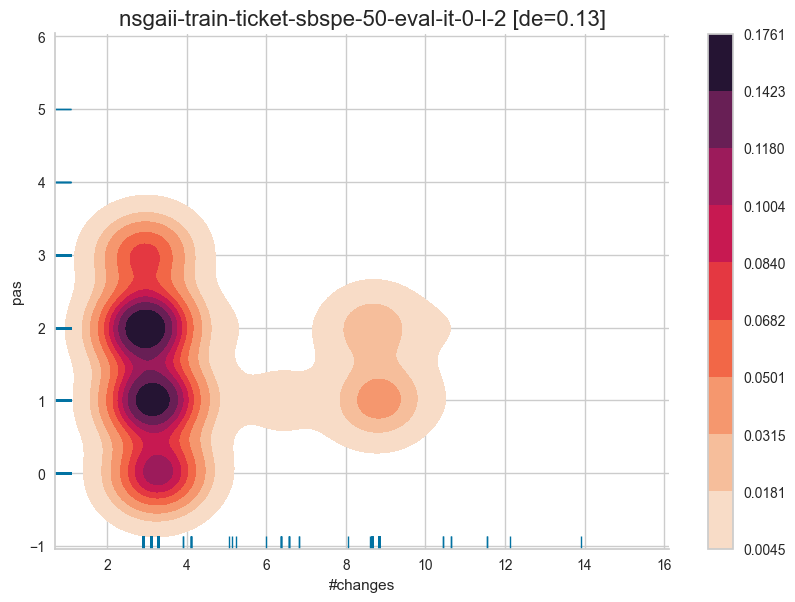

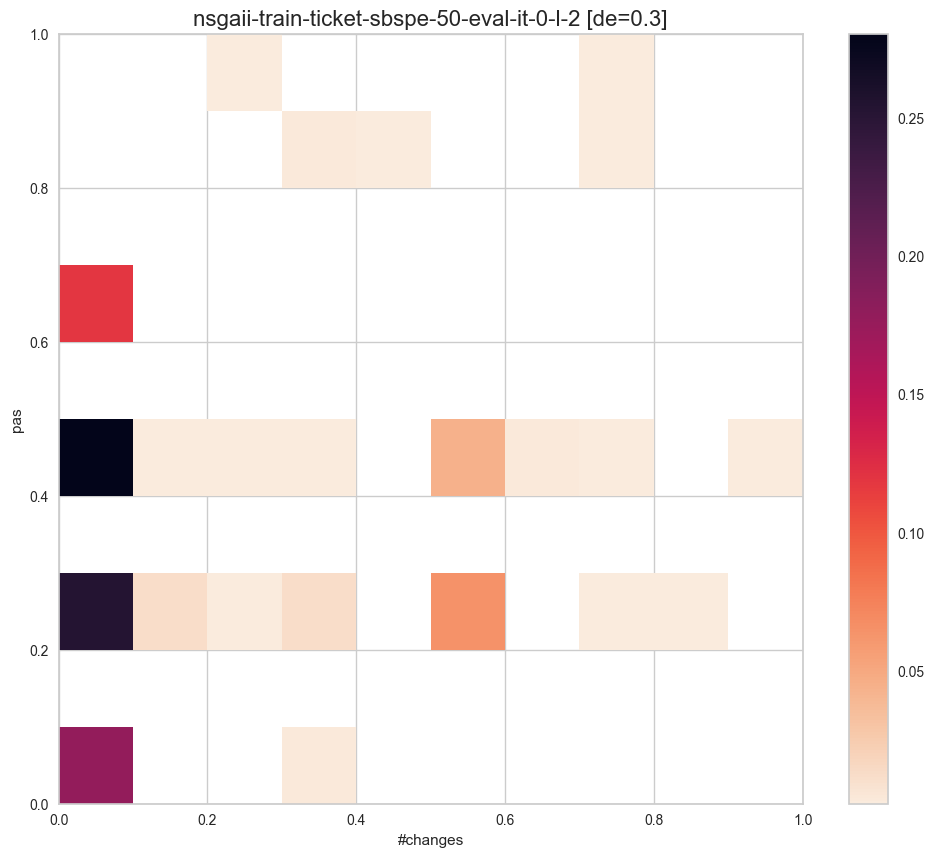

In [330]:
# Density plots for the 2D space of changes versus pas
it0_50_space.show_density_plot(objectives=OBJS_CHANGES_PAS, normalize=False) 
it0_50_space.show_density_plot(kind='bins', objectives=OBJS_CHANGES_PAS, normalize=True, bins=10)

In [331]:
# Entropy of 2D space
de_2D = it0_50_space.compute_density_entropy(normalize=True, bins=10)
print("The density entropy is:", de_2D)

The density entropy is: 0.2987550413519693


---
## **Iteration 1: Centroid 258 (interactive, 50)**
This centroid choice is about *very-few* changes [3.28] and *very-few* pas [0]. It also has basic performance and reliability.

In [332]:
# Initialize the project/file
it1_50_c258_space = ArchitectureSpaceAnalyzer(objectives=OBJS_CHANGES_PAS)
it1_50_c258_space.initialize_dataset(NSGAII_IT1_50_C258_PROJECT_NAME)
print(it1_50_c258_space.PROJECT_NAME)

it1_50_c258_space.set_labels(ALL_CLUSTER_LABELS)
it1_50_c258_space.CHANGES_LIMITS = CHANGES_LIMITS
it1_50_c258_space.PAS_LIMITS = PAS_LIMITS

# Read all the objectives and refactoring actions
# Note that length of sequences is 2
_ = it1_50_c258_space.read_file_batch(1,31, length=2, arguments=0, option='all')

project: nsgaii-train-ticket-sbspe-50-eval-it-1-l-2-centroid-258
objective files= 31
refactoring actions files= 31
nsgaii-train-ticket-sbspe-50-eval-it-1-l-2-centroid-258
Reading files ... 1 31 all
  file 0
  file 1
  file 2
  file 3
  file 4
  file 5
  file 6
  file 7
  file 8
  file 9
  file 10
  file 11
  file 12
  file 13
  file 14
  file 15
  file 16
  file 17
  file 18
  file 19
  file 20
  file 21
  file 22
  file 23
  file 24
  file 25
  file 26
  file 27
  file 28
  file 29
  file 30
done.


In [333]:
it1_50_c258_space.objectives_df.head()

solID     perfQ  reliability  #changes  pas
0    207  0.168745     0.661981      6.18  2.0
1    577  0.266925     0.294967      6.56  0.0
2    653  0.266856     0.482953      6.18  2.0
3    981  0.266925     0.294967      6.56  0.0
4   1330  0.149889     0.298885      6.56  0.0

Statistics for #changes and pas objectives.

In [334]:
it1_50_c258_space.objectives_df[OBJS_CHANGES_PAS].describe()

#changes         pas
count  496.000000  496.000000
mean     6.570302    1.320565
std      1.654663    0.903450
min      6.180000    0.000000
25%      6.180000    1.000000
50%      6.180000    1.000000
75%      6.370000    2.000000
max     25.310000    5.000000

In [335]:
#it1_50_c258_space.refactions_df.head()

### *Metrics*

In [336]:
ref50_it1_c258_pf = it1_50_c258_space.get_pareto_front()
#ref50_it1_c258_norm_pf = it1_50_c258_space.compute_pareto_front(invert_max=True)

# The reference front is the ref1000 space
metrics50_it1_c258_dict = it1_50_c258_space.compute_all_metrics(ref_point=(1,1), reference_front=ref1000_norm_pf)
metrics50_it1_c258_dict['point'] = 'it1-c258'
print("Pareto front metrics (#changes versus pas):")
print(metrics50_it1_c258_dict)

ref50_it1_c258_pf.head()

Pareto front metrics (#changes versus pas):
{'C_AB': 0.75, 'C_BA': 1.0, 'IGDPlus': 0.03496927843485372, 'HV': 0.9980135912179822, 'NPS': 7, 'NSolutions': 17, 'NSequences': 445, 'DE': 0.22166384462242136, 'point': 'it1-c258'}


#changes  pas
0      6.37  0.0
1      6.56  0.0
2      6.18  1.0
3      6.37  1.0
4      6.18  2.0

In [337]:
complete_pf = ref50_it1_c258_pf.merge(it1_50_c258_space.objectives_df, on=OBJS_CHANGES_PAS)
complete_pf = complete_pf.drop_duplicates(subset=PROBLEM_OBJECTIVES)
print(complete_pf.shape)
complete_pf.to_csv('./datasets/it1_50_c258_pf.csv', index=False)
#ref50_it1_c258_pf.merge(it1_50_c258_space.objectives_df, on=OBJS_CHANGES_PAS).to_csv('it1_50_c258_pf.csv', index=False)

it1_50_c258_space.objectives_df.drop_duplicates(subset=PROBLEM_OBJECTIVES).to_csv('./datasets/it1_50_c258.csv', index=False)

(80, 5)


### *Clustering*

In [338]:
# Try k-Means
#labels, _, silhouette = it1_50_c258_space.run_kmeans(k=5, show_silhouette=False) 

# Try agglomerative clustering
labels, _, silhouette = it1_50_c258_space.run_agglomerative(k=5, threshold=None, show_dendogram=False) 
it1_50_c258_space.assign_cluster_labels(labels) # This effectively assigns the labels

Number of clusters = 5
Labels for instances: [0 3 0 3 3 0 0 4 4 0 4 0 0 4 0 4 4 0 0 3 3 3 0 0 0 4 4 3 3 0 0 3 0 0 4 3 3
 0 3 4 4 0 0 4 3 4 0 4 4 3 0 3 0 0 2 4 4 4 3 3 0 0 0 0 0 4 3 0 3 2 0 0 0 4
 3 0 4 3 4 0 0 3 0 0 3 0 4 0 4 4 0 0 3 4 4 4 0 3 0 2 3 4 0 4 4 4 0 0 4 0 4
 4 3 0 4 0 0 3 3 4 4 0 0 0 4 4 3 0 0 0 3 0 3 4 4 4 0 0 4 0 4 4 4 0 4 0 3 0
 0 0 4 3 4 0 4 4 4 0 3 4 0 4 3 0 3 0 4 0 0 4 3 3 0 4 4 4 0 3 0 3 3 0 0 0 0
 4 3 4 4 0 4 0 0 0 0 3 3 0 3 0 0 4 3 4 4 4 0 0 0 0 3 3 0 4 4 0 0 0 4 0 0 4
 0 0 3 0 0 4 3 0 3 1 0 4 3 4 4 3 4 0 0 0 3 0 3 3 0 4 4 3 0 0 3 3 3 3 0 3 2
 0 2 3 0 3 4 4 0 0 0 4 0 4 0 3 4 0 0 3 0 4 0 3 0 0 4 4 4 0 4 0 3 3 0 4 4 0
 0 4 0 0 0 0 0 4 0 3 0 0 4 0 4 0 4 4 3 4 0 4 0 0 3 0 4 4 3 0 4 4 0 0 0 0 0
 4 0 0 3 0 0 4 0 0 3 4 4 0 0 0 0 0 0 0 0 3 0 3 0 4 0 4 0 0 0 4 0 0 0 4 0 3
 0 0 3 3 4 4 0 0 4 4 3 4 0 4 3 0 0 3 0 0 0 4 0 0 4 0 0 0 4 0 4 4 1 3 3 1 4
 2 3 4 4 4 1 1 4 4 0 0 4 0 3 3 4 4 4 4 3 4 4 0 0 0 3 0 0 0 0 4 4 4 0 4 3 0
 4 0 0 0 3 0 0 3 3 2 0 3 2 4 4 0 4 0 0 0 0 0 4 3 0 2 0 

perfQ  reliability  #changes  pas  cluster  \
14   0.171626     0.655447      6.18  2.0        0   
402  0.213536     0.307186     19.32  1.0        1   
69   0.213536     0.429078     12.93  1.0        2   
372  0.195683     0.319128      6.56  0.0        3   
159  0.206970     0.537210      6.37  1.0        4   

                           label  
14   - / - / very-few / very-few  
402       - / - / few / very-few  
69        - / - / few / very-few  
372  - / - / very-few / very-few  
159  - / - / very-few / very-few

In [339]:
it1_50_c258_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True)
#it1_50_c258_space.show_petal_plot(labels=True, size=(20,5))

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [340]:
it1_50_c258_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True, pfonly=True)

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [341]:
it1_50_c258_space.clusters_info()

  cluster 0 : 227 items 45.77 % - / - / very-few / very-few
  cluster 4 : 152 items 30.65 % - / - / very-few / very-few
  cluster 3 : 103 items 20.77 % - / - / very-few / very-few
  cluster 2 : 9 items 1.81 % - / - / few / very-few
  cluster 1 : 5 items 1.01 % - / - / few / very-few


In [342]:
it1_50_c258_space.describe_cluster_labels(objectives=OBJS_CHANGES_PAS)

Using predefined limits (0, 1.0)
Using predefined limits (2.5, 50)
Using predefined limits (0, 14)
Using predefined limits (0, 1.0)


objective    min    max  unit     label
5   #changes   2.40  11.94  unit  very-few
6   #changes  11.94  21.48  unit       few
7   #changes  21.48  31.02  unit   average
8   #changes  31.02  40.56  unit      some
9   #changes  40.56  50.10  unit      many
10       pas  -0.10   2.74  unit  very-few
11       pas   2.74   5.58  unit       few
12       pas   5.58   8.42  unit   average
13       pas   8.42  11.26  unit      some
14       pas  11.26  14.10  unit      many

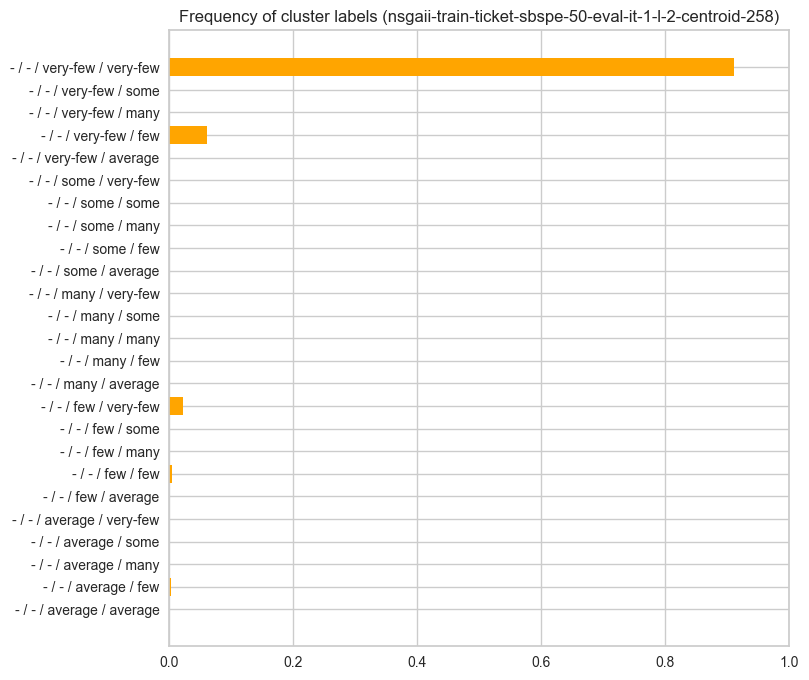

{'- / - / average / average': 0.0,
 '- / - / average / few': 0.0020161290322580645,
 '- / - / average / many': 0.0,
 '- / - / average / some': 0.0,
 '- / - / average / very-few': 0.0,
 '- / - / few / average': 0.0,
 '- / - / few / few': 0.004032258064516129,
 '- / - / few / many': 0.0,
 '- / - / few / some': 0.0,
 '- / - / few / very-few': 0.02217741935483871,
 '- / - / many / average': 0.0,
 '- / - / many / few': 0.0,
 '- / - / many / many': 0.0,
 '- / - / many / some': 0.0,
 '- / - / many / very-few': 0.0,
 '- / - / some / average': 0.0,
 '- / - / some / few': 0.0,
 '- / - / some / many': 0.0,
 '- / - / some / some': 0.0,
 '- / - / some / very-few': 0.0,
 '- / - / very-few / average': 0.0,
 '- / - / very-few / few': 0.06048387096774194,
 '- / - / very-few / many': 0.0,
 '- / - / very-few / some': 0.0,
 '- / - / very-few / very-few': 0.9112903225806451}

In [343]:
it1_50_c258_space.show_cluster_labels_distribution(size=(8,8))

### *Visualizations (density)*

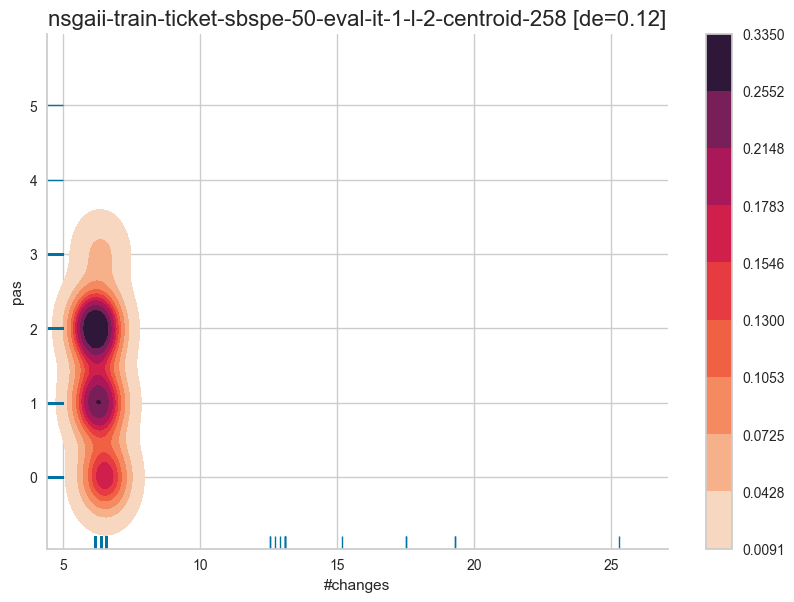

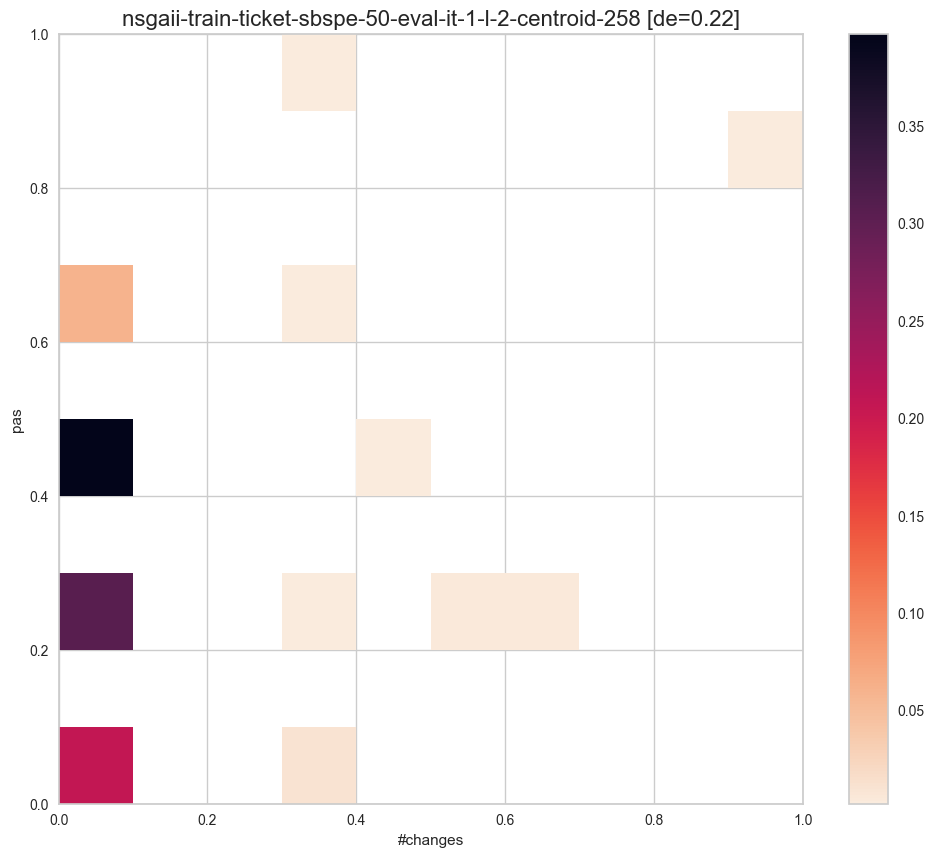

In [344]:
# Density plots for the 2D space of changes versus pas
it1_50_c258_space.show_density_plot(objectives=OBJS_CHANGES_PAS, normalize=False) 
it1_50_c258_space.show_density_plot(kind='bins', objectives=OBJS_CHANGES_PAS, normalize=True, bins=10)

In [345]:
# Entropy of 2D space
de_2D = it1_50_c258_space.compute_density_entropy(normalize=True, bins=10)
print("The density entropy is:", de_2D)

The density entropy is: 0.22166384462242136


---
## **Iteration 1: Centroid 223 (interactive, 50)**

This centroid choice is about *very-few* changes [2.1] and *very-few* pas [2]. It also has basic performance but good reliability.

In [346]:
# Initialize the project/file
it1_50_c223_space = ArchitectureSpaceAnalyzer(objectives=OBJS_CHANGES_PAS)
it1_50_c223_space.initialize_dataset(NSGAII_IT1_50_C223_PROJECT_NAME)
print(it1_50_c223_space.PROJECT_NAME)

it1_50_c223_space.set_labels(ALL_CLUSTER_LABELS)
it1_50_c223_space.CHANGES_LIMITS = CHANGES_LIMITS
it1_50_c223_space.PAS_LIMITS = PAS_LIMITS

# Read all the objectives and refactoring actions
# Note that length of sequences is 2
_ = it1_50_c223_space.read_file_batch(1,31, length=2, arguments=0, option='all')

project: nsgaii-train-ticket-sbspe-50-eval-it-1-l-2-centroid-223
objective files= 31
refactoring actions files= 31
nsgaii-train-ticket-sbspe-50-eval-it-1-l-2-centroid-223
Reading files ... 1 31 all
  file 0
  file 1
  file 2
  file 3
  file 4
  file 5
  file 6
  file 7
  file 8
  file 9
  file 10
  file 11
  file 12
  file 13
  file 14
  file 15
  file 16
  file 17
  file 18
  file 19
  file 20
  file 21
  file 22
  file 23
  file 24
  file 25
  file 26
  file 27
  file 28
  file 29
  file 30
done.


In [347]:
it1_50_c223_space.objectives_df.head()

solID     perfQ  reliability  #changes  pas
0    609  0.206919     0.659124      4.54  2.0
1    804  0.235470     0.432430      5.99  1.0
2   1370  0.233279     0.432747      6.18  4.0
3   1402  0.178755     0.847808      5.99  1.0
4   1179  0.233279     0.432747      6.18  4.0

Statistics for #changes and pas objectives.

In [348]:
it1_50_c223_space.objectives_df[OBJS_CHANGES_PAS].describe()

#changes         pas
count  496.000000  496.000000
mean     6.069940    1.645161
std      0.836774    0.751495
min      4.350000    0.000000
25%      5.990000    1.000000
50%      5.990000    2.000000
75%      5.990000    2.000000
max     14.130000    4.000000

In [349]:
#it1_50_c223_space.refactions_df()

### *Metrics*

In [350]:
ref50_it1_c223_pf = it1_50_c223_space.get_pareto_front()
#ref50_it1_c223_norm_pf = it1_50_c223_space.compute_pareto_front(invert_max=True)

# The reference front is the ref1000 space
metrics50_it1_c223_dict = it1_50_c223_space.compute_all_metrics(ref_point=(1,1), reference_front=ref1000_norm_pf)
metrics50_it1_c223_dict['point'] = 'it1-c223'
print("Pareto front metrics (#changes versus pas):")
print(metrics50_it1_c223_dict)

ref50_it1_c223_pf.head()

Pareto front metrics (#changes versus pas):
{'C_AB': 0.4166666666666667, 'C_BA': 1.0, 'IGDPlus': 0.1626456239631094, 'HV': 0.9483640081799591, 'NPS': 6, 'NSolutions': 24, 'NSequences': 457, 'DE': 0.23168156431954698, 'point': 'it1-c223'}


#changes  pas
0      4.54  1.0
1      6.18  0.0
2      4.35  2.0
3      4.54  2.0
4      5.99  1.0

In [351]:
complete_pf = ref50_it1_c223_pf.merge(it1_50_c223_space.objectives_df, on=OBJS_CHANGES_PAS)
complete_pf = complete_pf.drop_duplicates(subset=PROBLEM_OBJECTIVES)
print(complete_pf.shape)
complete_pf.to_csv('./datasets/it1_50_c223_pf.csv', index=False)
#ref50_it1_c223_pf.merge(it1_50_c223_space.objectives_df, on=OBJS_CHANGES_PAS).to_csv('it1_50_c223_pf.csv', index=False)

it1_50_c223_space.objectives_df.drop_duplicates(subset=PROBLEM_OBJECTIVES).to_csv('./datasets/it1_50_c223.csv', index=False)

(56, 5)


### *Clustering*

In [352]:
# Try k-Means
#labels, _, silhouette = it1_50_c258_space.run_kmeans(k=5, show_silhouette=False) 

# Try agglomerative clustering
labels, _, silhouette = it1_50_c223_space.run_agglomerative(k=5, threshold=None, show_dendogram=False) 
it1_50_c223_space.assign_cluster_labels(labels) # This effectively assigns the labels

Number of clusters = 5
Labels for instances: [2 0 3 0 3 2 4 4 4 0 4 4 0 4 4 4 2 4 4 0 4 0 4 0 4 4 2 4 0 0 4 4 0 4 4 4 4
 0 0 0 0 4 0 0 0 4 0 0 2 2 0 4 0 4 0 0 4 2 2 0 4 0 0 0 4 4 4 0 4 0 0 0 0 4
 0 0 0 4 0 0 2 4 0 4 0 3 3 3 0 4 4 3 0 3 4 3 4 0 4 4 1 4 0 3 3 0 4 4 0 0 0
 4 4 4 2 4 4 0 4 4 0 0 0 0 0 0 0 4 4 4 0 3 0 0 0 0 4 3 0 3 0 3 4 0 4 4 0 4
 0 4 0 0 4 4 0 0 0 0 4 0 4 4 0 4 3 0 0 4 0 3 0 4 0 0 0 0 4 4 4 4 4 0 0 0 4
 0 4 0 0 4 0 0 4 4 0 4 1 0 3 4 3 0 0 4 0 0 4 0 4 4 4 0 0 4 4 4 0 4 0 0 0 0
 4 4 0 0 4 4 4 3 0 0 0 3 0 3 3 3 3 4 0 4 0 4 0 1 0 0 1 0 3 0 0 4 0 0 4 4 0
 4 4 0 0 3 4 0 3 4 4 4 0 0 4 4 0 0 0 4 0 0 0 0 0 0 0 4 0 0 4 4 4 0 0 0 4 0
 0 0 4 0 0 0 0 4 4 4 4 0 4 4 0 0 0 0 4 4 0 0 4 0 0 4 4 0 3 4 4 0 4 3 0 0 0
 4 0 0 3 4 4 4 3 4 3 4 3 4 4 3 4 4 4 3 2 4 2 4 0 4 4 2 2 4 0 4 4 0 0 4 0 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 0 0 4 4 0 0 0 4 4 0 0 4 0 4 4 3 4
 4 3 4 4 4 4 4 4 4 4 2 3 0 0 4 4 3 4 4 0 0 0 4 0 0 4 4 2 0 1 0 4 0 4 0 4 0
 0 0 4 0 4 0 4 3 0 4 3 4 0 0 4 0 3 4 0 4 0 0 4 4 1 0 0 

perfQ  reliability  #changes  pas  cluster  \
486  0.212566     0.713457      6.18  1.0        0   
100  0.056472     0.848388     11.79  3.0        1   
0    0.206919     0.659124      4.54  2.0        2   
405  0.209154     0.725755      6.18  3.0        3   
303  0.209150     0.780977      5.99  2.0        4   

                           label  
486  - / - / very-few / very-few  
100       - / - / very-few / few  
0    - / - / very-few / very-few  
405       - / - / very-few / few  
303  - / - / very-few / very-few

In [353]:
it1_50_c223_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True)
#it1_50_c258_space.show_petal_plot(labels=True, size=(20,5))

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [354]:
it1_50_c223_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True, pfonly=True)

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [355]:
it1_50_c223_space.clusters_info()

  cluster 4 : 216 items 43.55 % - / - / very-few / very-few
  cluster 0 : 213 items 42.94 % - / - / very-few / very-few
  cluster 3 : 44 items 8.87 % - / - / very-few / few
  cluster 2 : 16 items 3.23 % - / - / very-few / very-few
  cluster 1 : 7 items 1.41 % - / - / very-few / few


In [356]:
it1_50_c223_space.describe_cluster_labels(objectives=OBJS_CHANGES_PAS)

Using predefined limits (0, 1.0)
Using predefined limits (2.5, 50)
Using predefined limits (0, 14)
Using predefined limits (0, 1.0)


objective    min    max  unit     label
5   #changes   2.40  11.94  unit  very-few
6   #changes  11.94  21.48  unit       few
7   #changes  21.48  31.02  unit   average
8   #changes  31.02  40.56  unit      some
9   #changes  40.56  50.10  unit      many
10       pas  -0.10   2.74  unit  very-few
11       pas   2.74   5.58  unit       few
12       pas   5.58   8.42  unit   average
13       pas   8.42  11.26  unit      some
14       pas  11.26  14.10  unit      many

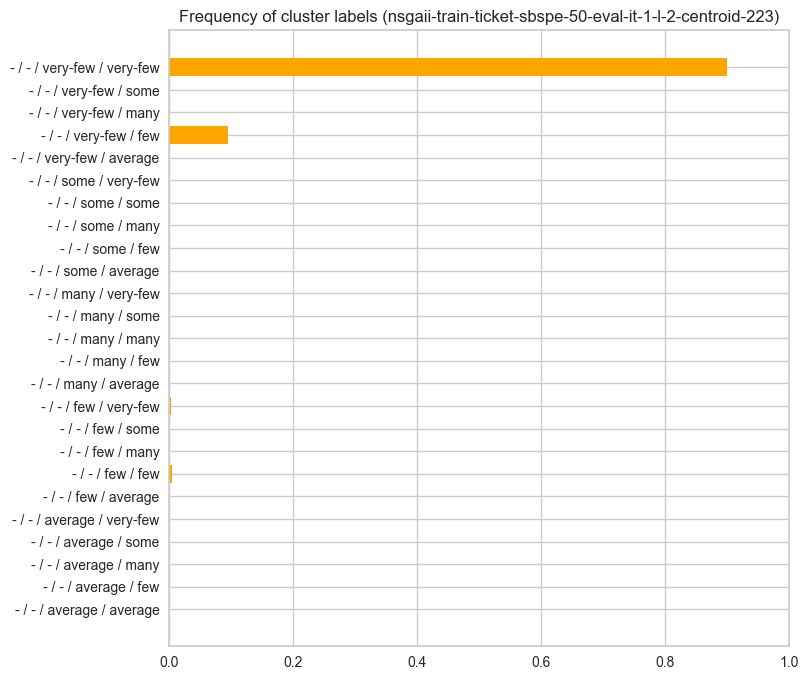

{'- / - / average / average': 0.0,
 '- / - / average / few': 0.0,
 '- / - / average / many': 0.0,
 '- / - / average / some': 0.0,
 '- / - / average / very-few': 0.0,
 '- / - / few / average': 0.0,
 '- / - / few / few': 0.004032258064516129,
 '- / - / few / many': 0.0,
 '- / - / few / some': 0.0,
 '- / - / few / very-few': 0.0020161290322580645,
 '- / - / many / average': 0.0,
 '- / - / many / few': 0.0,
 '- / - / many / many': 0.0,
 '- / - / many / some': 0.0,
 '- / - / many / very-few': 0.0,
 '- / - / some / average': 0.0,
 '- / - / some / few': 0.0,
 '- / - / some / many': 0.0,
 '- / - / some / some': 0.0,
 '- / - / some / very-few': 0.0,
 '- / - / very-few / average': 0.0,
 '- / - / very-few / few': 0.09475806451612903,
 '- / - / very-few / many': 0.0,
 '- / - / very-few / some': 0.0,
 '- / - / very-few / very-few': 0.8991935483870968}

In [357]:
it1_50_c223_space.show_cluster_labels_distribution(size=(8,8))

### *Visualization (density)*

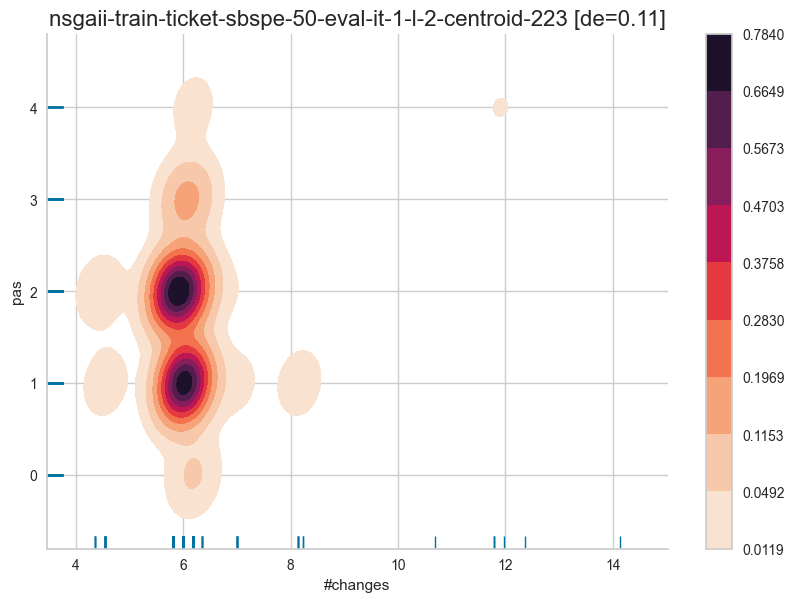

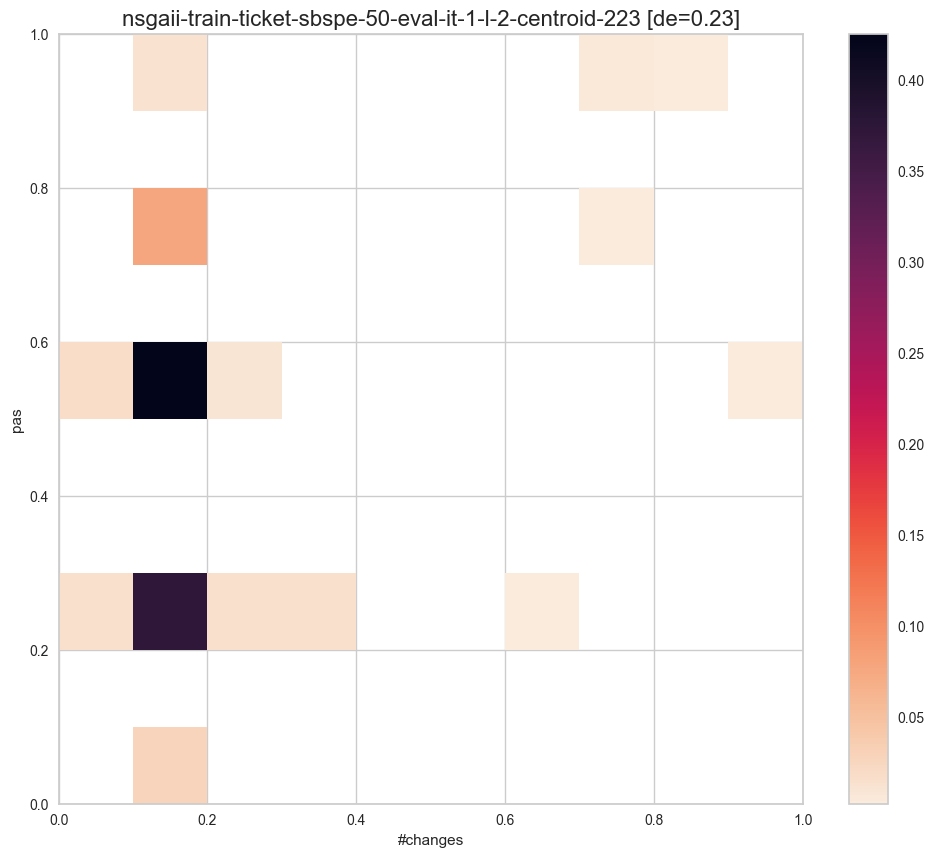

In [358]:
# Density plots for the 2D space of changes versus pas
it1_50_c223_space.show_density_plot(objectives=OBJS_CHANGES_PAS, normalize=False) 
it1_50_c223_space.show_density_plot(kind='bins', objectives=OBJS_CHANGES_PAS, normalize=True, bins=10) 

In [359]:
# Entropy of 2D space
de_2D = it1_50_c223_space.compute_density_entropy(normalize=True, bins=10)
print("The density entropy is:", de_2D)

The density entropy is: 0.23168156431954698


---
## **Iteration 0 (non-interactive, 100)**

In [360]:
# Initialize the project/file
it0_100_space = ArchitectureSpaceAnalyzer(objectives=OBJS_CHANGES_PAS)
it0_100_space.initialize_dataset(NSGAII_IT0_100_PROJECT_NAME)
print(it0_100_space.PROJECT_NAME)

it0_100_space.set_labels(ALL_CLUSTER_LABELS)
it0_100_space.CHANGES_LIMITS = CHANGES_LIMITS
it0_100_space.PAS_LIMITS = PAS_LIMITS

# Read all the objectives and refactoring actions
# Note that length of sequences is 4
_ = it0_100_space.read_file_batch(1,31, length=4, arguments=0, option='all')

project: nsgaii-train-ticket-sbspe-100-eval-it-0
objective files= 31
refactoring actions files= 31
nsgaii-train-ticket-sbspe-100-eval-it-0
Reading files ... 1 31 all
  file 0
  file 1
  file 2
  file 3
  file 4
  file 5
  file 6
  file 7
  file 8
  file 9
  file 10
  file 11
  file 12
  file 13
  file 14
  file 15
  file 16
  file 17
  file 18
  file 19
  file 20
  file 21
  file 22
  file 23
  file 24
  file 25
  file 26
  file 27
  file 28
  file 29
  file 30
done.


In [361]:
it0_100_space.objectives_df.head()

solID     perfQ  reliability  #changes  pas
0    289  0.145989     0.872976      5.80  3.0
1   1221  0.183599     0.465675      6.18  0.0
2   1265  0.323642     0.779689      9.75  2.0
3   1459  0.264819     0.779689      5.80  2.0
4   2081  0.065988     0.792661      5.99  1.0

Statistics for changes and pas objectives.

In [362]:
it0_100_space.objectives_df[OBJS_CHANGES_PAS].describe()

#changes         pas
count  495.000000  495.000000
mean     7.067737    2.090909
std      2.913605    1.084403
min      5.800000    0.000000
25%      5.800000    1.000000
50%      5.990000    2.000000
75%      6.180000    3.000000
max     32.800000    7.000000

In [363]:
#it0_100_space.refactions_df.head()

### *Metrics*

In [364]:
ref100_it0_pf = it0_100_space.get_pareto_front()
#ref100_it0_norm_pf = it0_100_space.compute_pareto_front(invert_max=True, objectives=objs_changes_pas)

# The reference front is the ref1000 space
metrics100_it0_dict = it0_100_space.compute_all_metrics(ref_point=(1,1), reference_front=ref1000_norm_pf)
metrics100_it0_dict['point'] = 'it-01-baseline'
print("Pareto front metrics (#changes versus pas):")
print(metrics100_it0_dict)

ref100_it0_pf.head()

Pareto front metrics (#changes versus pas):
{'C_AB': 0.6666666666666666, 'C_BA': 1.0, 'IGDPlus': 0.07152634179622143, 'HV': 0.996984126984127, 'NPS': 13, 'NSolutions': 73, 'NSequences': 473, 'DE': 0.3769990068133898, 'point': 'it-01-baseline'}


#changes  pas
0      6.18  0.0
1      6.56  0.0
2      5.99  1.0
3      5.99  1.0
4      6.18  1.0

In [365]:
complete_pf = ref100_it0_pf.merge(it0_100_space.objectives_df, on=OBJS_CHANGES_PAS)
complete_pf = complete_pf.drop_duplicates(subset=PROBLEM_OBJECTIVES)
print(complete_pf.shape)
complete_pf.to_csv('./datasets/it0_100_pf.csv', index=False)
#ref100_it0_pf.merge(it0_100_space.objectives_df, on=OBJS_CHANGES_PAS).to_csv('it0_100_pf.csv', index=False)

it0_100_space.objectives_df.drop_duplicates(subset=PROBLEM_OBJECTIVES).to_csv('./datasets/it1_100.csv', index=False)

(88, 5)


### *Clustering*
This is not strictly needed for the RQ, but it is for computing the scatter plot below.

In [366]:
# Try k-Means
#labels, _, silhouette = it0_100_space.run_kmeans(k=5, show_silhouette=False) 

# Try agglomerative clustering
labels, _, silhouette = it0_100_space.run_agglomerative(k=5, threshold=None, show_dendogram=False) 
it0_100_space.assign_cluster_labels(labels) # This effectively assigns the labels

Number of clusters = 5
Labels for instances: [3 1 0 4 1 2 0 0 0 1 0 0 1 1 3 1 4 1 3 4 3 1 4 3 1 3 4 1 3 3 4 4 0 1 4 4 0
 3 2 0 0 1 3 1 4 4 4 3 3 0 3 4 1 0 3 2 1 3 3 4 4 4 3 3 4 3 1 3 2 3 1 3 3 4
 4 1 4 4 3 3 3 0 4 1 3 4 2 0 0 0 3 1 0 4 1 1 1 4 0 4 0 3 4 3 1 0 0 1 3 1 4
 4 3 0 1 4 4 2 2 0 1 0 0 1 0 3 4 1 1 0 4 0 1 0 0 0 0 3 2 3 2 1 0 4 4 3 1 1
 4 3 4 1 1 3 1 1 1 4 4 1 4 4 3 1 0 3 3 1 4 1 4 3 1 4 3 3 4 4 1 3 1 1 4 3 1
 4 3 4 3 4 4 3 4 3 4 1 4 1 2 1 1 3 4 3 4 4 4 4 4 1 4 1 3 1 3 1 1 4 1 1 1 3
 3 1 4 1 3 4 2 4 1 0 3 3 1 1 4 1 4 3 0 4 1 4 1 3 3 4 1 0 3 1 4 1 3 4 4 3 1
 0 1 3 2 1 4 3 0 1 1 1 1 4 4 1 1 0 4 2 0 1 1 0 1 4 4 4 1 4 3 4 1 1 3 4 1 3
 1 1 4 3 4 4 4 4 3 4 1 1 3 3 1 3 3 4 3 4 3 3 3 4 1 4 2 0 3 0 3 1 1 3 1 4 4
 3 1 1 4 3 0 3 4 0 3 3 4 4 4 3 3 4 3 1 4 4 3 4 3 3 3 3 4 4 4 3 3 4 3 4 4 1
 3 1 4 3 1 4 4 1 4 4 4 3 3 3 4 4 3 3 4 3 3 4 4 3 4 3 4 4 3 1 0 4 3 3 0 3 1
 4 1 3 4 1 1 3 3 3 4 0 1 3 4 1 1 3 1 3 1 3 1 3 3 4 1 1 1 4 3 1 3 1 1 3 4 4
 4 4 3 1 4 3 4 2 4 2 2 3 2 0 0 3 1 4 4 4 3 1 0 3 1 4 3 

perfQ  reliability  #changes  pas  cluster  \
87   0.283400     0.221991     11.93  1.0        0   
296  0.197176     0.719936      6.18  1.0        1   
453  0.198819     0.846598     14.54  6.0        2   
71   0.198819     0.846598      5.99  3.0        3   
26   0.204506     0.844112      5.99  2.0        4   

                           label  
87   - / - / very-few / very-few  
296  - / - / very-few / very-few  
453        - / - / few / average  
71        - / - / very-few / few  
26   - / - / very-few / very-few

In [367]:
it0_100_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True)
#it0_100_space.show_petal_plot(labels=True, size=(20,5))

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [368]:
it0_100_space.show_scatter_plot(x='#changes', y='pas', show_all_labels=True, pfonly=True)

Using alternatives as prototypes ... []


alt.HConcatChart(...)

In [369]:
it0_100_space.clusters_info()

  cluster 4 : 150 items 30.30 % - / - / very-few / very-few
  cluster 3 : 143 items 28.89 % - / - / very-few / few
  cluster 1 : 131 items 26.46 % - / - / very-few / very-few
  cluster 0 : 52 items 10.51 % - / - / very-few / very-few
  cluster 2 : 19 items 3.84 % - / - / few / average


In [370]:
it0_100_space.describe_cluster_labels(objectives=OBJS_CHANGES_PAS)

Using predefined limits (0, 1.0)
Using predefined limits (2.5, 50)
Using predefined limits (0, 14)
Using predefined limits (0, 1.0)


objective    min    max  unit     label
5   #changes   2.40  11.94  unit  very-few
6   #changes  11.94  21.48  unit       few
7   #changes  21.48  31.02  unit   average
8   #changes  31.02  40.56  unit      some
9   #changes  40.56  50.10  unit      many
10       pas  -0.10   2.74  unit  very-few
11       pas   2.74   5.58  unit       few
12       pas   5.58   8.42  unit   average
13       pas   8.42  11.26  unit      some
14       pas  11.26  14.10  unit      many

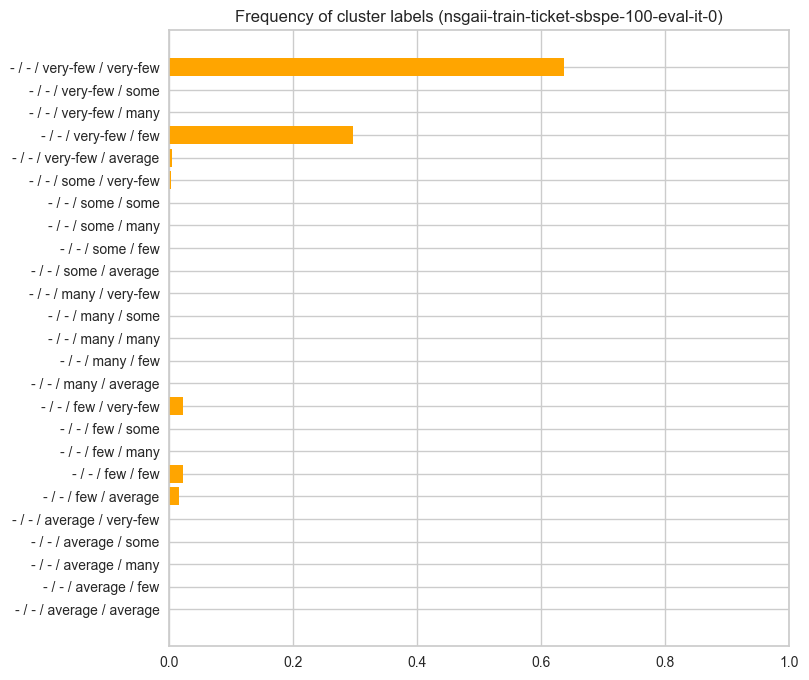

{'- / - / average / average': 0.0,
 '- / - / average / few': 0.0,
 '- / - / average / many': 0.0,
 '- / - / average / some': 0.0,
 '- / - / average / very-few': 0.0,
 '- / - / few / average': 0.01616161616161616,
 '- / - / few / few': 0.022222222222222223,
 '- / - / few / many': 0.0,
 '- / - / few / some': 0.0,
 '- / - / few / very-few': 0.022222222222222223,
 '- / - / many / average': 0.0,
 '- / - / many / few': 0.0,
 '- / - / many / many': 0.0,
 '- / - / many / some': 0.0,
 '- / - / many / very-few': 0.0,
 '- / - / some / average': 0.0,
 '- / - / some / few': 0.0,
 '- / - / some / many': 0.0,
 '- / - / some / some': 0.0,
 '- / - / some / very-few': 0.00202020202020202,
 '- / - / very-few / average': 0.00404040404040404,
 '- / - / very-few / few': 0.296969696969697,
 '- / - / very-few / many': 0.0,
 '- / - / very-few / some': 0.0,
 '- / - / very-few / very-few': 0.6363636363636364}

In [371]:
it0_100_space.show_cluster_labels_distribution(size=(8,8))

### *Visualizations (density)*

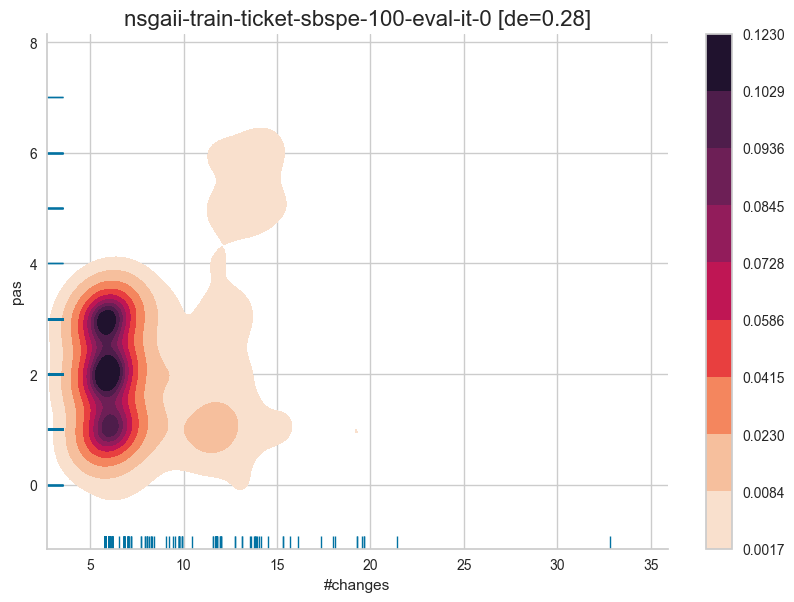

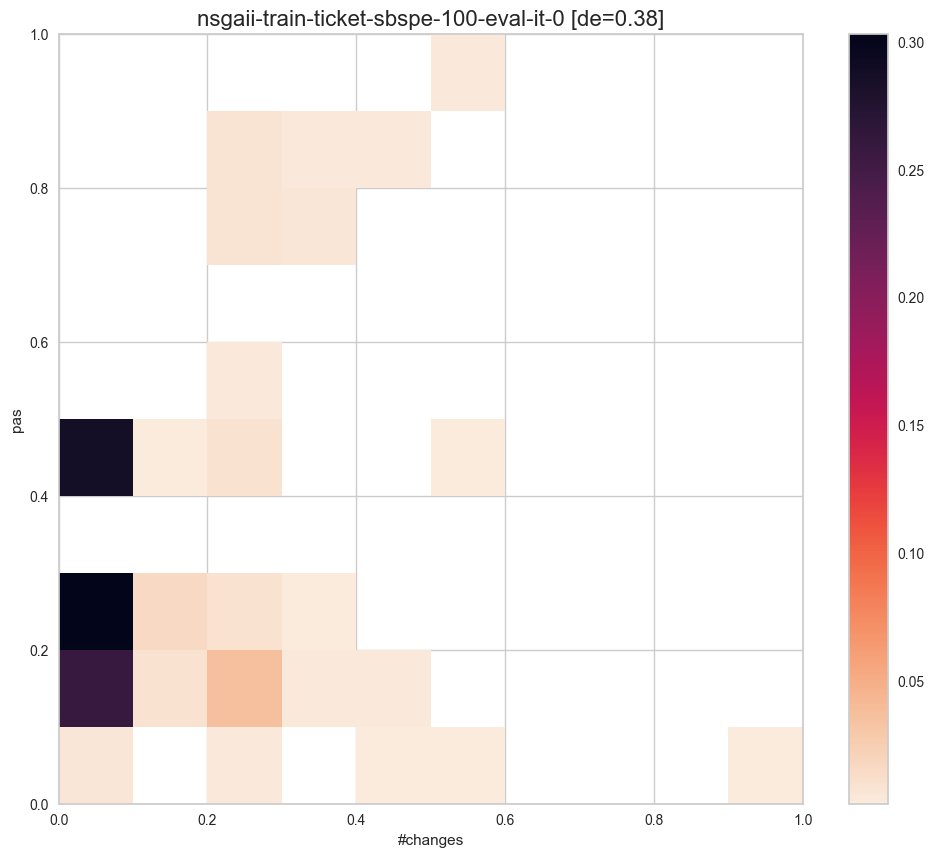

In [372]:
# Density plots for the 2D space of changes versus pas
it0_100_space.show_density_plot(objectives=OBJS_CHANGES_PAS, normalize=False) 
it0_100_space.show_density_plot(kind='bins', objectives=OBJS_CHANGES_PAS, normalize=True, bins=10) 

In [373]:
# Entropy of 2D space
de_2D = it0_100_space.compute_density_entropy(normalize=True, bins=10)
print("The density entropy is:", de_2D)

The density entropy is: 0.3769990068133898


---

## **Misc**

### *Comparison of Metrics*

In [374]:
# Concatenation of all the metrics
s1 = pd.DataFrame([metrics1000_dict])
#s2 = pd.DataFrame([metrics50_it0_dict])
s3 = pd.DataFrame([metrics50_it1_c258_dict])
s4 = pd.DataFrame([metrics50_it1_c223_dict])
s5 = pd.DataFrame([metrics100_it0_dict])
metrics_df = pd.concat([s1, s3, s4, s5])
metrics_df

C_AB  C_BA   IGDPlus        HV  NPS  NSolutions  NSequences        DE  \
0  1.000000   1.0  0.000000  0.999045   24          99         492  0.440297   
0  0.750000   1.0  0.034969  0.998014    7          17         445  0.221664   
0  0.416667   1.0  0.162646  0.948364    6          24         457  0.231682   
0  0.666667   1.0  0.071526  0.996984   13          73         473  0.376999   

            point  
0       reference  
0        it1-c258  
0        it1-c223  
0  it-01-baseline

In [375]:
#dfi.export(metrics_df,'table.png', table_conversion = 'matplotlib')
#Image.open('table.png')

In [376]:
# Looking at the different cluster labels from all the spaces
a = set(ref1000_space.CLUSTER_LABELS.values())
b = set(it0_50_space.CLUSTER_LABELS.values())
c = set(it1_50_c258_space.CLUSTER_LABELS.values())
d = set(it1_50_c223_space.CLUSTER_LABELS.values())
e = set(it0_100_space.CLUSTER_LABELS.values())

ALL_CLUSTER_LABELS = a.union(b,c,d,e)
print(len(ALL_CLUSTER_LABELS)) 
list(ALL_CLUSTER_LABELS)

6


['- / - / very-few / very-few',
 '- / - / few / average',
 '- / - / few / very-few',
 '- / - / many / many',
 '- / - / few / few',
 '- / - / very-few / few']

In [377]:
a = set(ref1000_space.tagged_objectives_df['label'])
b = set(it0_50_space.tagged_objectives_df['label'])
c = set(it1_50_c258_space.tagged_objectives_df['label'])
d = set(it1_50_c223_space.tagged_objectives_df['label'])
e = set(it0_100_space.tagged_objectives_df['label'])

ALL_CLUSTER_LABELS = a.union(b,c,d,e)
print(len(ALL_CLUSTER_LABELS)) 
list(ALL_CLUSTER_LABELS)

10


['- / - / average / few',
 '- / - / very-few / very-few',
 '- / - / average / very-few',
 '- / - / few / very-few',
 '- / - / very-few / average',
 '- / - / few / few',
 '- / - / few / average',
 '- / - / some / very-few',
 '- / - / very-few / few',
 '- / - / many / many']

In [378]:
c1_max = ref1000_space.objectives_df['#changes'].max()
c2_max = it0_50_space.objectives_df['#changes'].max()
c3_max = it1_50_c258_space.objectives_df['#changes'].max()
c4_max = it1_50_c223_space.objectives_df['#changes'].max()
c5_max = it0_100_space.objectives_df['#changes'].max()
max_changes = max([c1_max,c2_max,c3_max,c4_max,c5_max])
print('max #changes=', max_changes)

max #changes= 48.45000000000002


In [379]:
c1_min = ref1000_space.objectives_df['#changes'].min()
c2_min = it0_50_space.objectives_df['#changes'].min()
c3_min = it1_50_c258_space.objectives_df['#changes'].min()
c4_min = it1_50_c223_space.objectives_df['#changes'].min()
c5_min = it0_100_space.objectives_df['#changes'].min()
min_changes = min([c1_min,c2_min,c3_min,c4_min,c5_min])
print('main #changes=', min_changes)

main #changes= 2.9


In [380]:
p1_max = ref1000_space.objectives_df['pas'].max()
p2_max = it0_50_space.objectives_df['pas'].max()
p3_max = it1_50_c258_space.objectives_df['pas'].max()
p4_max = it1_50_c223_space.objectives_df['pas'].max()
p5_max = it0_100_space.objectives_df['pas'].max()
max_pas = max([p1_max,p2_max,p3_max,p4_max,p5_max])
print('max #pas=', max_pas)

max #pas= 14.0


In [381]:
p1_min = ref1000_space.objectives_df['pas'].min()
p2_min = it0_50_space.objectives_df['pas'].min()
p3_min = it1_50_c258_space.objectives_df['pas'].min()
p4_min = it1_50_c223_space.objectives_df['pas'].min()
p5_min = it0_100_space.objectives_df['pas'].min()
min_pas = min([p1_min,p2_min,p3_min,p4_min,p5_min])
print('min #pas=', min_pas)

min #pas= 0.0


# **ANALYSIS OF REFACTORING SPACES**

## **Reference Pareto Front** (1000)
These are types of refactoring actions (without their arguments)

In [382]:
ref1000_space.refactions_df.head() 

solID                                    op1  \
0    193  Move_Operation_New_Component_New_Node   
1    305  Move_Operation_New_Component_New_Node   
2  10436  Move_Operation_New_Component_New_Node   
3  27162               Move_Operation_Component   
4  27194               Move_Operation_Component   

                                     op2  \
0  Move_Operation_New_Component_New_Node   
1  Move_Operation_New_Component_New_Node   
2  Move_Operation_New_Component_New_Node   
3  Move_Operation_New_Component_New_Node   
4  Move_Operation_New_Component_New_Node   

                                     op3  \
0  Move_Operation_New_Component_New_Node   
1  Move_Operation_New_Component_New_Node   
2               Move_Operation_Component   
3                Move_Component_New_Node   
4  Move_Operation_New_Component_New_Node   

                                     op4  
0  Move_Operation_New_Component_New_Node  
1  Move_Operation_New_Component_New_Node  
2               Move_Operation_Component  
3  Move_Operation_New_Component_New_Node  
4               Move_Operation_Component

In [383]:
operations_ref1000 = ref1000_space.get_candidate_operations()
#print(len(operations_ref1000), operations_ref1000)

refactions: 495
all operations: 1980


refactions: 495
all operations: 1980


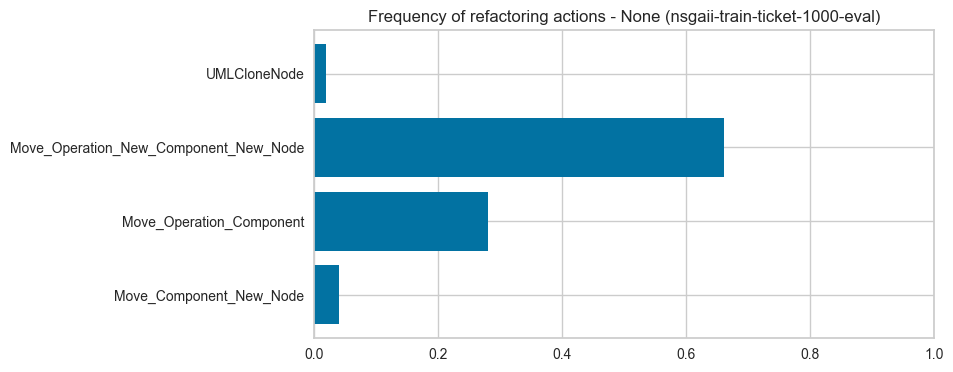

(array(['Move_Component_New_Node', 'Move_Operation_Component',
        'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
       dtype='<U37'),
 array([0.04040404, 0.27979798, 0.66060606, 0.01919192]))

In [384]:
ref1000_space.show_refactions_distribution(size=(8,4), normalize=True)

refactions: 495
all operations: 495
refactions: 495
all operations: 495
refactions: 495
all operations: 495
refactions: 495
all operations: 495


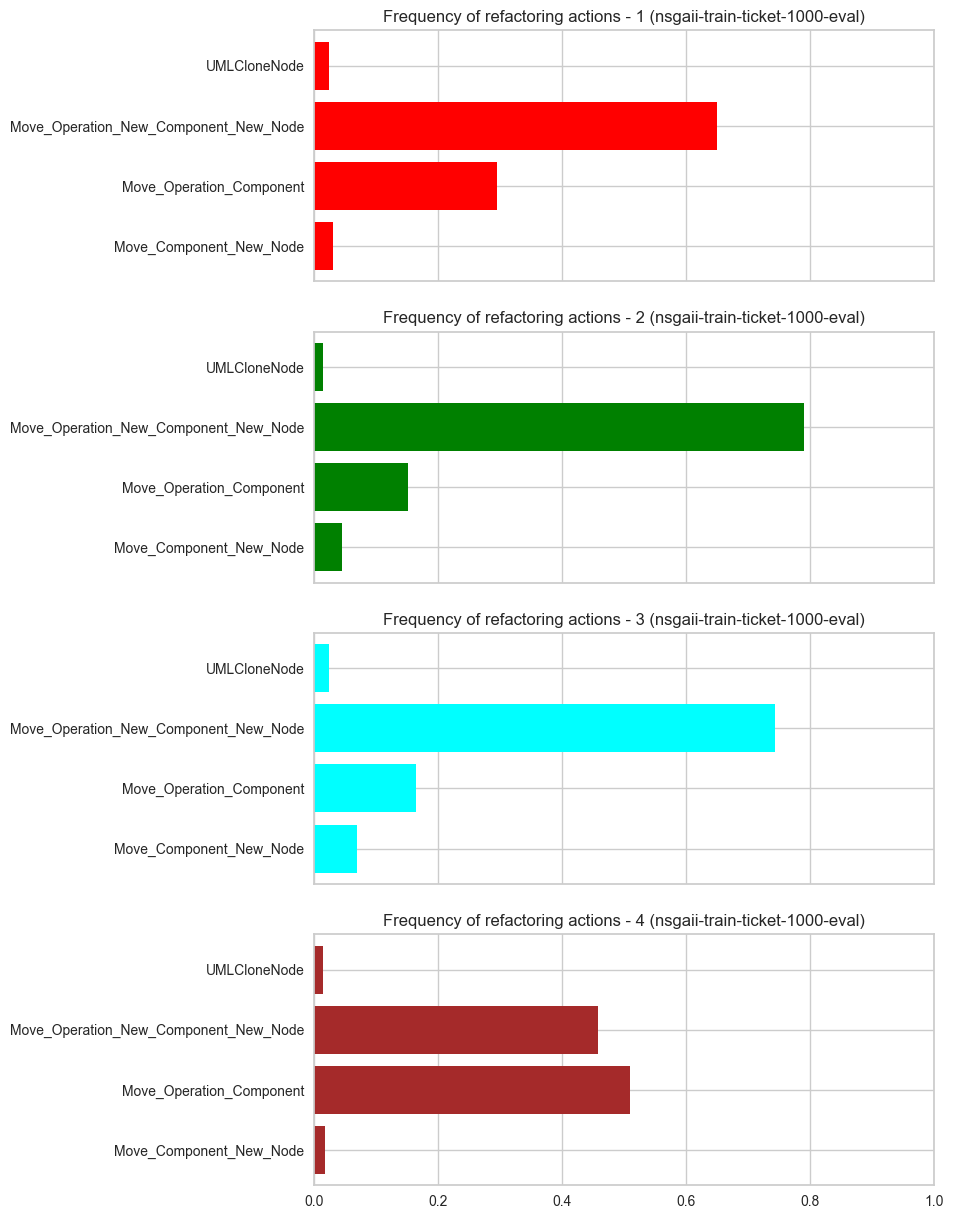

([array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37')],
 [array([0.03030303, 0.29494949, 0.65050505, 0.02424242]),
  array([0.04444444, 0.15151515, 0.78989899, 0.01414141]),
  array([0.06868687, 0.16363636, 0.74343434, 0.02424242]),
  array([0.01818182, 0.50909091, 0.45858586, 0.01414141])])

In [385]:
ref1000_space.show_refactions_distribution(size=(8,15), option=0, normalize=True)

## **Iteration 1: Centroid 258** (interactive, 50)

In [386]:
it1_50_c258_space.refactions_df.head()

solID                                    op1  \
0    207  Move_Operation_New_Component_New_Node   
1    577               Move_Operation_Component   
2    653  Move_Operation_New_Component_New_Node   
3    981               Move_Operation_Component   
4   1330               Move_Operation_Component   

                                     op2  
0  Move_Operation_New_Component_New_Node  
1               Move_Operation_Component  
2  Move_Operation_New_Component_New_Node  
3               Move_Operation_Component  
4               Move_Operation_Component

In [387]:
# centroid 258 --> solID = 1334
it0_50_space.refactions_df[it0_50_space.refactions_df.solID == 1334]
# Move_Operation_Component(modify)	Move_Operation_Component(rebook)

solID                       op1                       op2
258   1334  Move_Operation_Component  Move_Operation_Component

In [388]:
#prefix_sequence_centroid258_2args = ['Move_Operation_Component(modify,Rebook)',	'Move_Operation_Component(rebook,Sso)']
prefix_sequence_centroid258 = ['Move_Operation_Component',	'Move_Operation_Component']
it1_50_c258_space.add_sequence_prefix(prefix_sequence_centroid258).head()

solID                       op1                       op2  \
0    207  Move_Operation_Component  Move_Operation_Component   
1    577  Move_Operation_Component  Move_Operation_Component   
2    653  Move_Operation_Component  Move_Operation_Component   
3    981  Move_Operation_Component  Move_Operation_Component   
4   1330  Move_Operation_Component  Move_Operation_Component   

                                     op3  \
0  Move_Operation_New_Component_New_Node   
1               Move_Operation_Component   
2  Move_Operation_New_Component_New_Node   
3               Move_Operation_Component   
4               Move_Operation_Component   

                                     op4  
0  Move_Operation_New_Component_New_Node  
1               Move_Operation_Component  
2  Move_Operation_New_Component_New_Node  
3               Move_Operation_Component  
4               Move_Operation_Component

In [389]:
operations_centroid258 = it1_50_c258_space.get_candidate_operations()
#print(len(operations_centroid258), operations_centroid258)

refactions: 496
all operations: 1984


refactions: 496
all operations: 1984


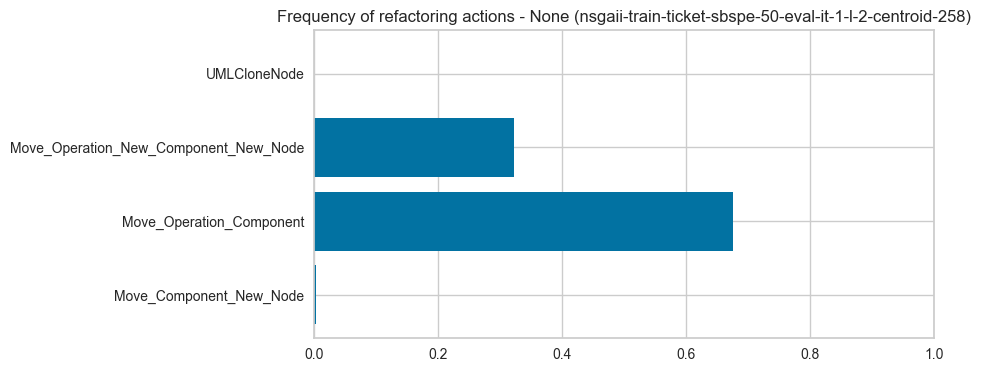

(array(['Move_Component_New_Node', 'Move_Operation_Component',
        'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
       dtype='<U37'),
 array([2.52016129e-03, 6.74899194e-01, 3.22076613e-01, 5.04032258e-04]))

In [390]:
it1_50_c258_space.show_refactions_distribution(size=(8,4), normalize=True)

refactions: 496
all operations: 496
refactions: 496
all operations: 496
refactions: 496
all operations: 496
refactions: 496
all operations: 496


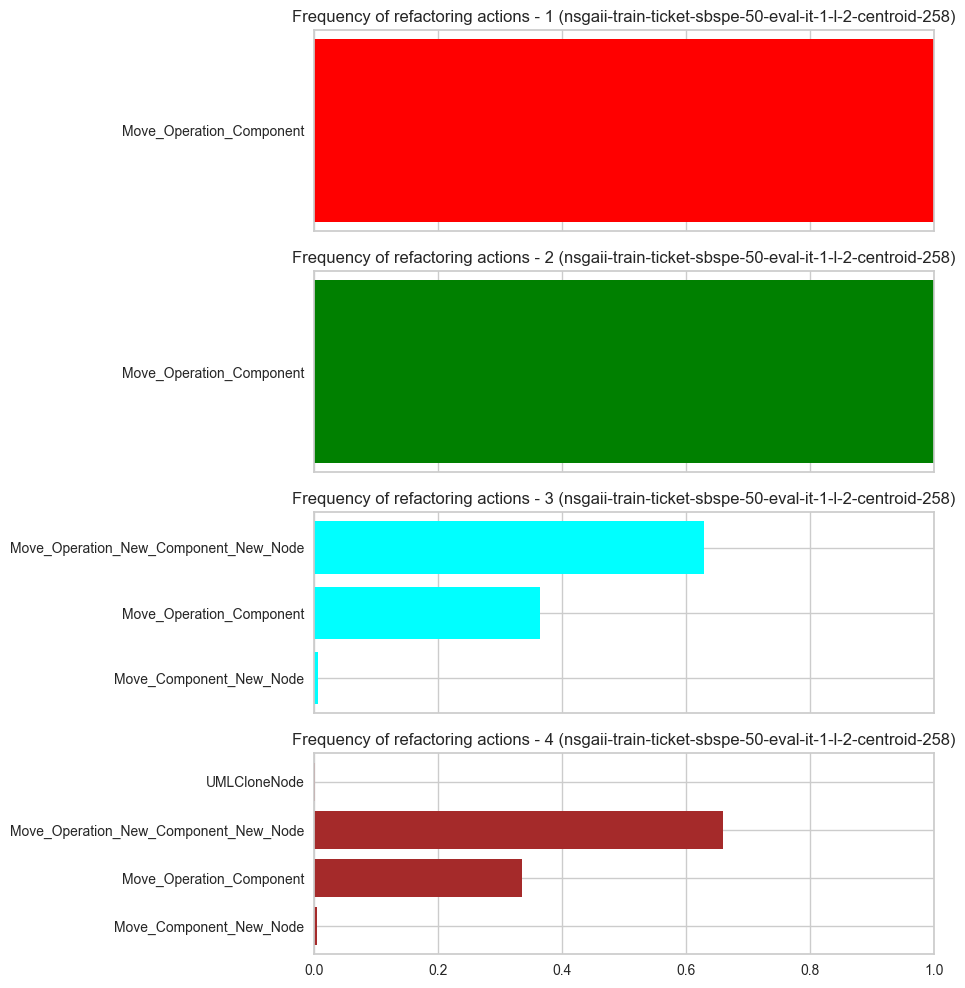

([array(['Move_Operation_Component'], dtype='<U24'),
  array(['Move_Operation_Component'], dtype='<U24'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node'], dtype='<U37'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37')],
 [array([1.]),
  array([1.]),
  array([0.00604839, 0.36491935, 0.62903226]),
  array([0.00403226, 0.33467742, 0.65927419, 0.00201613])])

In [391]:
countops_it1_50_c258 = it1_50_c258_space.show_refactions_distribution(size=(8,12), option=0, normalize=True)
countops_it1_50_c258

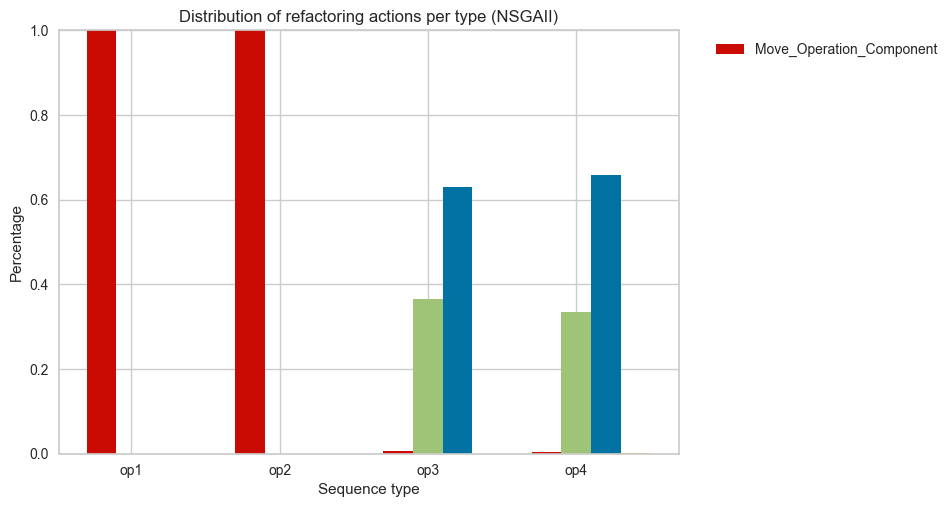

In [392]:
_ = it1_50_c258_space.plot_barchart_group(countops_it1_50_c258, title='(NSGAII)')

## **Iteration 1: Centroid 223 (interactive, 50)**

In [393]:
it1_50_c223_space.refactions_df.head()

solID                       op1                                    op2
0    609  Move_Operation_Component                Move_Component_New_Node
1    804  Move_Operation_Component  Move_Operation_New_Component_New_Node
2   1370  Move_Operation_Component               Move_Operation_Component
3   1402  Move_Operation_Component  Move_Operation_New_Component_New_Node
4   1179  Move_Operation_Component               Move_Operation_Component

In [394]:
# centroid 223 --> solID = 584 (cluster 3)
it0_50_space.refactions_df[it0_50_space.refactions_df.solID == 584]
# Move_Operation_New_Component_New_Node(findAll,New-Component_uckvimuprr)	Move_Operation_New_Component_New_Node(findall,New-Component_vsytcmjsan)

solID                                    op1  \
223    584  Move_Operation_New_Component_New_Node   

                                       op2  
223  Move_Operation_New_Component_New_Node

In [395]:
prefix_sequence_centroid223 = ['Move_Operation_New_Component_New_Node',	'Move_Operation_New_Component_New_Node']
it1_50_c223_space.add_sequence_prefix(prefix_sequence_centroid223).head()

solID                                    op1  \
0    609  Move_Operation_New_Component_New_Node   
1    804  Move_Operation_New_Component_New_Node   
2   1370  Move_Operation_New_Component_New_Node   
3   1402  Move_Operation_New_Component_New_Node   
4   1179  Move_Operation_New_Component_New_Node   

                                     op2                       op3  \
0  Move_Operation_New_Component_New_Node  Move_Operation_Component   
1  Move_Operation_New_Component_New_Node  Move_Operation_Component   
2  Move_Operation_New_Component_New_Node  Move_Operation_Component   
3  Move_Operation_New_Component_New_Node  Move_Operation_Component   
4  Move_Operation_New_Component_New_Node  Move_Operation_Component   

                                     op4  
0                Move_Component_New_Node  
1  Move_Operation_New_Component_New_Node  
2               Move_Operation_Component  
3  Move_Operation_New_Component_New_Node  
4               Move_Operation_Component

In [396]:
operations_centroid223 = it1_50_c223_space.get_candidate_operations()
#print(len(operations_centroid223), operations_centroid223)

refactions: 496
all operations: 1984


refactions: 496
all operations: 1984


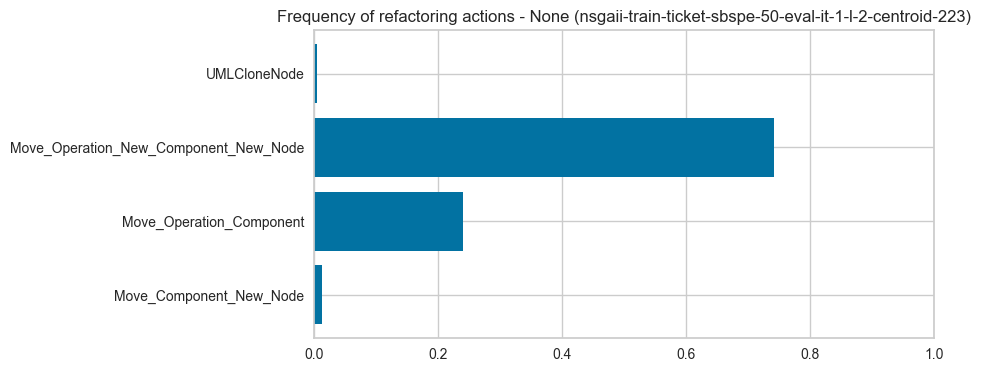

(array(['Move_Component_New_Node', 'Move_Operation_Component',
        'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
       dtype='<U37'),
 array([0.01310484, 0.24042339, 0.74143145, 0.00504032]))

In [397]:
it1_50_c223_space.show_refactions_distribution(size=(8,4), normalize=True)

refactions: 496
all operations: 496
refactions: 496
all operations: 496
refactions: 496
all operations: 496
refactions: 496
all operations: 496


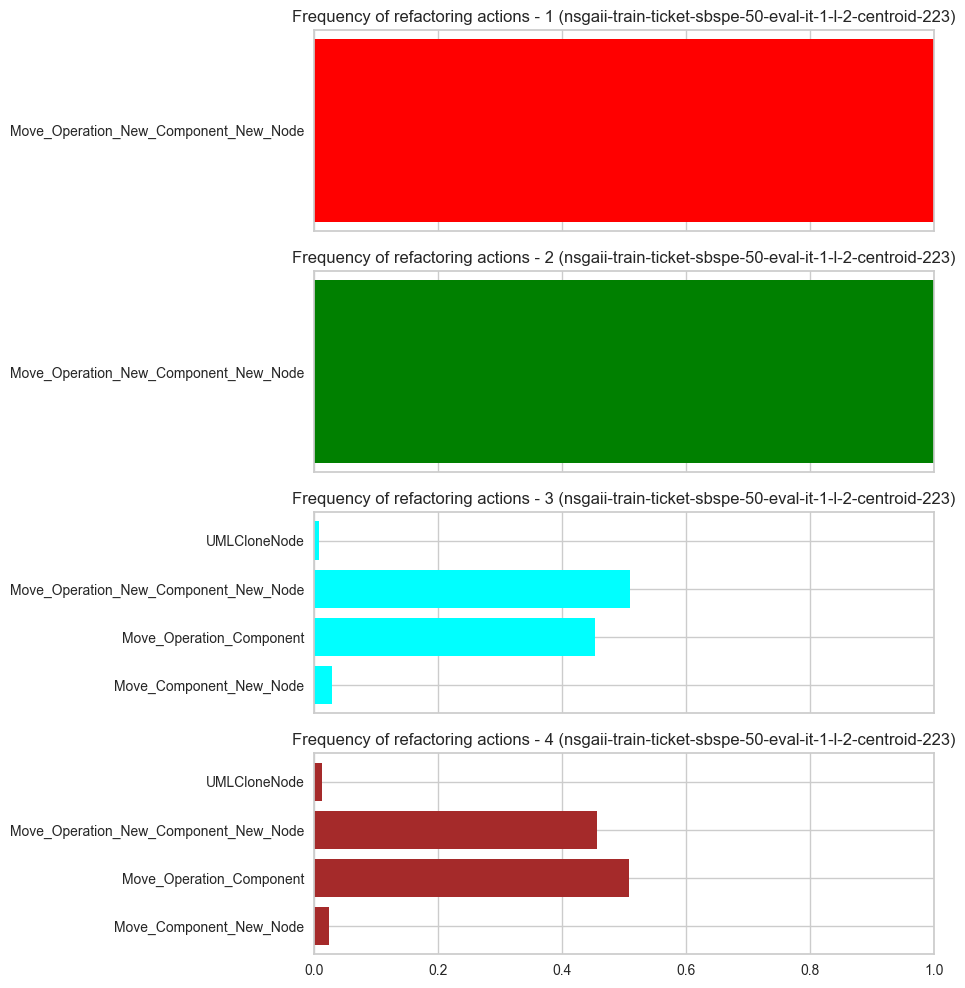

([array(['Move_Operation_New_Component_New_Node'], dtype='<U37'),
  array(['Move_Operation_New_Component_New_Node'], dtype='<U37'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37')],
 [array([1.]),
  array([1.]),
  array([0.02822581, 0.45362903, 0.51008065, 0.00806452]),
  array([0.02419355, 0.50806452, 0.45564516, 0.01209677])])

In [398]:
countops_it1_50_c223 = it1_50_c223_space.show_refactions_distribution(size=(8,12), option=0, normalize=True)
countops_it1_50_c223

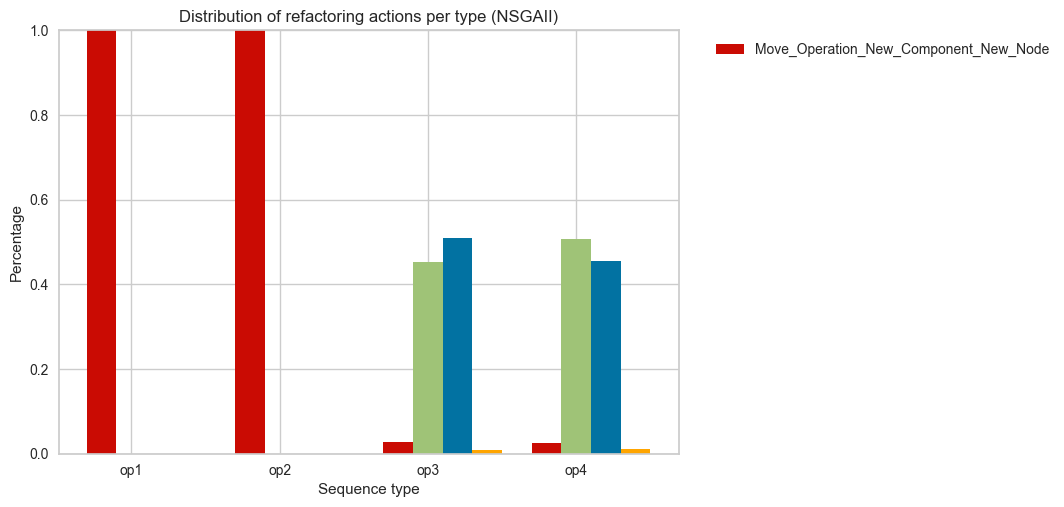

In [399]:
_ = it1_50_c223_space.plot_barchart_group(countops_it1_50_c223, title='(NSGAII)')

## **Iteration 0: (non-interactive, 100)**

In [400]:
it0_100_space.refactions_df.head()

solID                                    op1  \
0    289  Move_Operation_New_Component_New_Node   
1   1221  Move_Operation_New_Component_New_Node   
2   1265  Move_Operation_New_Component_New_Node   
3   1459  Move_Operation_New_Component_New_Node   
4   2081  Move_Operation_New_Component_New_Node   

                                     op2  \
0  Move_Operation_New_Component_New_Node   
1               Move_Operation_Component   
2                Move_Component_New_Node   
3  Move_Operation_New_Component_New_Node   
4  Move_Operation_New_Component_New_Node   

                                     op3  \
0  Move_Operation_New_Component_New_Node   
1  Move_Operation_New_Component_New_Node   
2  Move_Operation_New_Component_New_Node   
3  Move_Operation_New_Component_New_Node   
4  Move_Operation_New_Component_New_Node   

                                     op4  
0  Move_Operation_New_Component_New_Node  
1               Move_Operation_Component  
2  Move_Operation_New_Component_New_Node  
3  Move_Operation_New_Component_New_Node  
4               Move_Operation_Component

In [401]:
operations_ref100 = it0_100_space.get_candidate_operations()
#print(len(operations_ref100), operations_ref100)

refactions: 495
all operations: 1980


refactions: 495
all operations: 1980


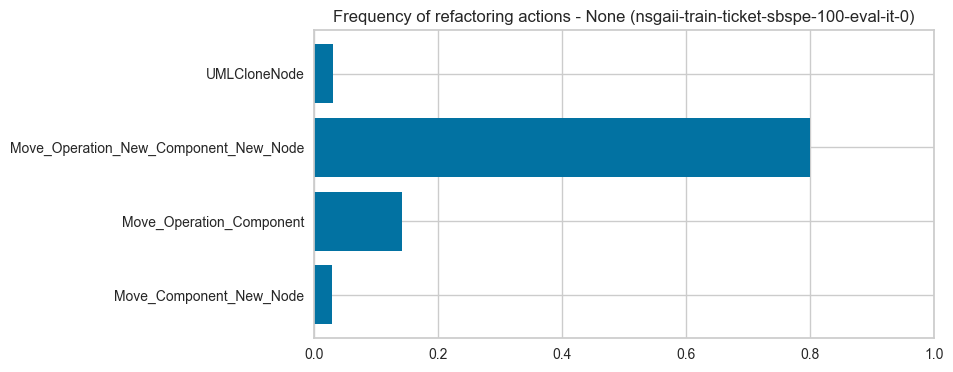

(array(['Move_Component_New_Node', 'Move_Operation_Component',
        'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
       dtype='<U37'),
 array([0.02828283, 0.14141414, 0.80050505, 0.02979798]))

In [402]:
it0_100_space.show_refactions_distribution(size=(8,4), normalize=True)

refactions: 495
all operations: 495
refactions: 495
all operations: 495
refactions: 495
all operations: 495
refactions: 495
all operations: 495


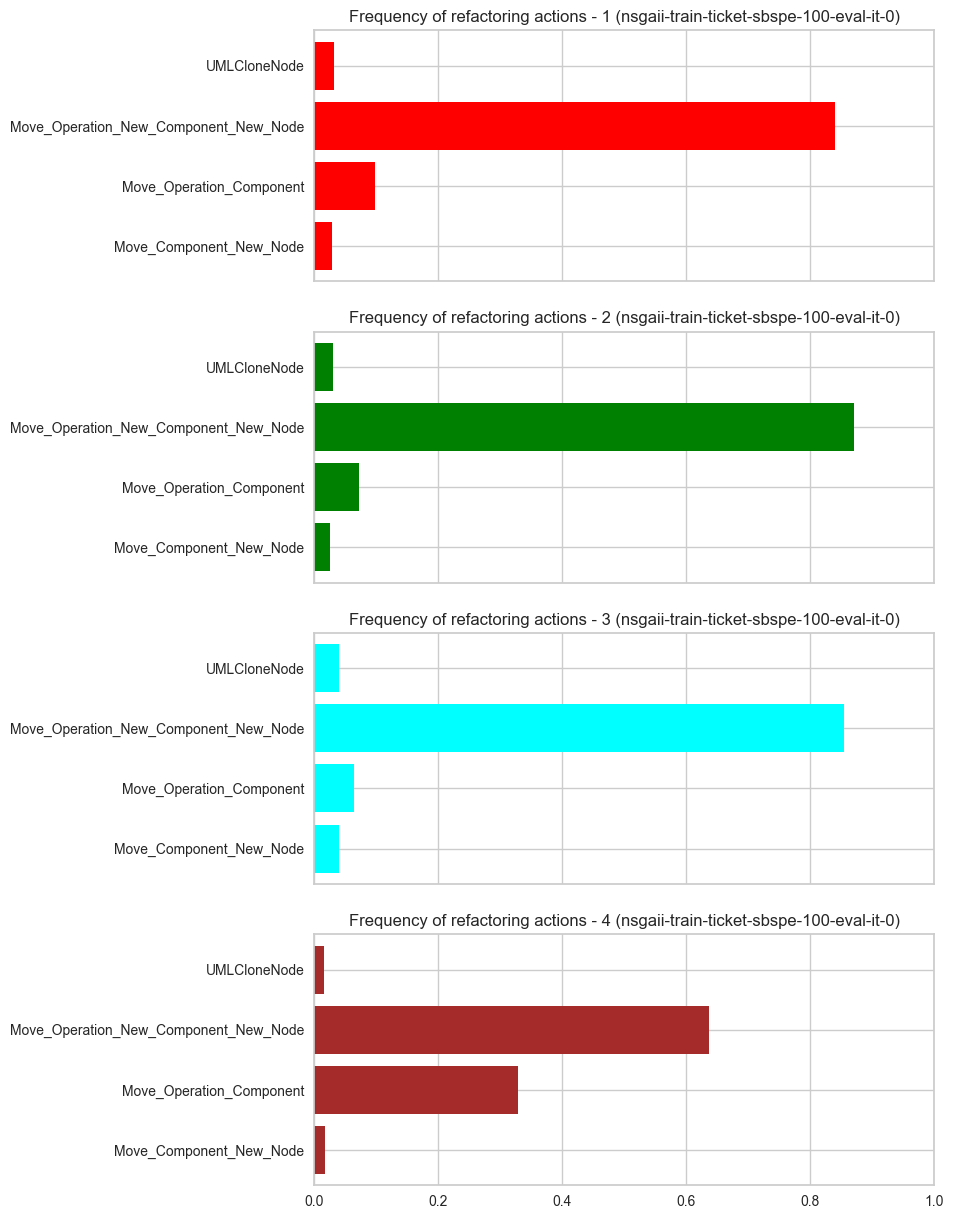

([array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37'),
  array(['Move_Component_New_Node', 'Move_Operation_Component',
         'Move_Operation_New_Component_New_Node', 'UMLCloneNode'],
        dtype='<U37')],
 [array([0.02828283, 0.0989899 , 0.84040404, 0.03232323]),
  array([0.02626263, 0.07272727, 0.87070707, 0.03030303]),
  array([0.04040404, 0.06464646, 0.85454545, 0.04040404]),
  array([0.01818182, 0.32929293, 0.63636364, 0.01616162])])

In [403]:
countops_it0_100 = it0_100_space.show_refactions_distribution(size=(8,15), option=0, normalize=True)
countops_it0_100

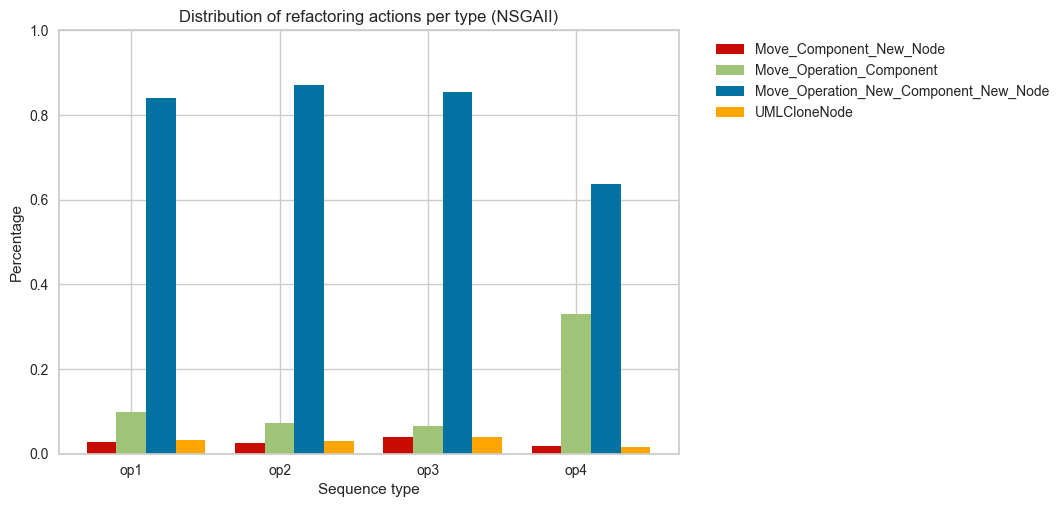

In [404]:
_ = it0_100_space.plot_barchart_group(countops_it0_100, title='(NSGAII)')

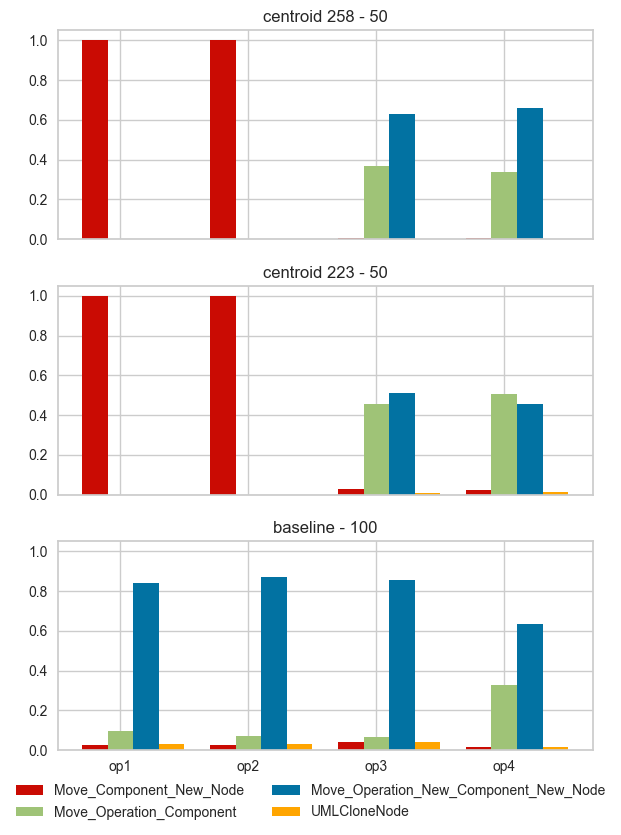

In [405]:
# Combination of all the plots for NSGAII
fig, axes = plt.subplots(3, sharey=True, sharex=True, figsize=(6,8))
#fig.suptitle('Frequency of actions per sequence position (train-ticket, NSGAII)')
#fig.suptitle('NSGAII (PF)')
lines, labels = it0_100_space.plot_barchart_group(countops_it1_50_c258, ax=axes[0], title='centroid 258 - 50')
lines, labels = it0_100_space.plot_barchart_group(countops_it1_50_c223, ax=axes[1], title='centroid 223 - 50')
lines, labels = it0_100_space.plot_barchart_group(countops_it0_100, ax=axes[2], title='baseline - 100')
fig.legend(lines, labels, ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.05), fontsize=10)
fig.tight_layout()
plt.show()

In [406]:
ALL_OPERATIONS = ['Move_Component_New_Node', 'Move_Operation_Component','Move_Operation_New_Component_New_Node', 'UMLCloneNode']

# This is a fix for the two particular cases of the centroids
countops_it1_50_c258[0][0] = np.array(ALL_OPERATIONS)
countops_it1_50_c258[0][1] = np.array(ALL_OPERATIONS)
countops_it1_50_c258[0][2] = np.array(ALL_OPERATIONS)
countops_it1_50_c258[1][0] = [0.0] + [1. ] + [0.0, 0.0]
countops_it1_50_c258[1][1] = [0.0] + [1. ] + [0.0, 0.0]
countops_it1_50_c258[1][2] = [0.00604839, 0.36491935, 0.62903226] + [0.0]

countops_it1_50_c223[0][0] = np.array(ALL_OPERATIONS)
countops_it1_50_c223[0][1] = np.array(ALL_OPERATIONS)
countops_it1_50_c223[1][0] = [0.0, 0.0] + [1. ] + [0.0]
countops_it1_50_c223[1][1] = [0.0, 0.0] + [1. ] + [0.0]

In [407]:
REFACTIONS_NAMES = {
    'Move_Component_New_Node': 'ReDe',
    'Move_Operation_Component': 'MO2C',
    'Move_Operation_New_Component_New_Node': 'MO2N',
    'UMLCloneNode': 'Clon'
}

index1, index2, column1 = get_values_as_dataframe(countops_it1_50_c258, 'trainticket (nsgaii)', 'c258')
_, _, column2 = get_values_as_dataframe(countops_it1_50_c223, 'trainticket (nsgaii)', 'c223')
_, _, column3 = get_values_as_dataframe(countops_it0_100, 'trainticket (nsgaii)', 'baseline')
all_columns = {k: v for d in [column1, column2, column3] for k, v in d.items()}
all_df = pd.DataFrame(data=all_columns, index=[index1,index2])
all_df = all_df.reset_index().rename(columns={'level_0':'pos', 'level_1': 'ref. actions'})
all_df['pos'] = [1]*4 + [2]*4 + [3]*4 + [4]*4
all_df[('ref. actions', '')] = all_df[('ref. actions', '')].replace(REFACTIONS_NAMES)
all_df.to_csv('./datasets/nsgaii-refactions-trainticket.csv', index=False)
all_df

pos ref. actions trainticket (nsgaii)                    
                                    c258      c223  baseline
0    1         ReDe             0.000000  0.000000  0.028283
1    1         MO2C             1.000000  0.000000  0.098990
2    1         MO2N             0.000000  1.000000  0.840404
3    1         Clon             0.000000  0.000000  0.032323
4    2         ReDe             0.000000  0.000000  0.026263
5    2         MO2C             1.000000  0.000000  0.072727
6    2         MO2N             0.000000  1.000000  0.870707
7    2         Clon             0.000000  0.000000  0.030303
8    3         ReDe             0.006048  0.028226  0.040404
9    3         MO2C             0.364919  0.453629  0.064646
10   3         MO2N             0.629032  0.510081  0.854545
11   3         Clon             0.000000  0.008065  0.040404
12   4         ReDe             0.004032  0.024194  0.018182
13   4         MO2C             0.334677  0.508065  0.329293
14   4         MO2N             0.659274  0.455645  0.636364
15   4         Clon             0.002016  0.012097  0.016162

In [408]:
# Showing it styled
cmap = sns.color_palette('viridis_r', as_cmap=True)
styled_df = all_df.style.background_gradient(cmap=cmap, subset=list(all_columns.keys()), vmin=0.0, vmax=1.0).format(precision=2).hide()
styled_df

In [409]:
#!pip install imgkit --quiet # For rendering images from HTML tables

In [410]:
#!sudo apt-get install wkhtmltopdf

In [411]:
#import imgkit
# Conversion to an image
#html = styled_df.to_html()
#imgkit.from_string(html, 'styled_table.png')
#Image.open('styled_table.png')

## **Comparison of prefix trees (types)**

In [437]:
# We need to consolidate all the refactoring actions of all the iterations
all_operations = set()
all_operations = all_operations.union(operations_ref1000, operations_centroid258, operations_centroid223, operations_ref100)
print("Operation reference (1000): ", len(operations_ref1000), len(set(operations_ref1000)))
print("Operation centroid258 (50): ", len(operations_centroid258), len(set(operations_centroid258)))
print("Operation centroid223 (50): ", len(operations_centroid223), len(set(operations_centroid223)))
print("Operation reference (100): ", len(operations_ref100), len(set(operations_ref100)))
print("All operations (intersection): ", len(all_operations))

# This is an encoder for all the iterations
global_le = ref1000_space.create_encoder(all_operations)

Operation reference (1000):  1980 4
Operation centroid258 (50):  1984 4
Operation centroid223 (50):  1984 4
Operation reference (100):  1980 4
All operations (intersection):  4


### *Codes and trees for Reference Pareto Front*

In [438]:
codes, encoder = ref1000_space.get_codes(use_alphabet=True, encoder=global_le)
unique_codes_ref1000 = dict(codes) # Note that duplicate codes are discarded (only one of the duplicates is kept)

refactions: 495
all operations: 1980
4 Distinct (individual) refactoring actions: {'Move_Component_New_Node', 'Move_Operation_New_Component_New_Node', 'Move_Operation_Component', 'UMLCloneNode'}
encoding refactions: 495
Sequence codes: 495 [('cccc', 193), ('cccc', 305), ('ccbb', 10436), ('bcac', 27162), ('bccb', 27194), ('cbac', 27814), ('bcaa', 28476), ('ccbb', 28752), ('cccc', 26574), ('cbcc', 26708), ('bccb', 10046), ('bcbb', 11903), ('bcbb', 18826), ('bccb', 28801), ('dccc', 28786), ('accb', 28782), ('cccc', 435), ('cccb', 17935), ('ccbb', 20766), ('bccc', 25509), ('cccb', 26249), ('ccbb', 26361), ('bccc', 11155), ('bccc', 25959), ('dcbb', 27121), ('cccb', 28831), ('cccc', 28712), ('bccb', 28659), ('cccb', 28846), ('cccc', 28830), ('cccc', 28827), ('cccb', 28826), ('cccc', 1246), ('cccb', 1571), ('ccbb', 14917), ('cccb', 20857), ('ccbb', 27303), ('cccb', 26907), ('bccc', 28487), ('cccb', 28732), ('ccbc', 28533), ('cccc', 11907), ('cccc', 28121), ('ccbb', 28475), ('cbcb', 19680), ('

hamming


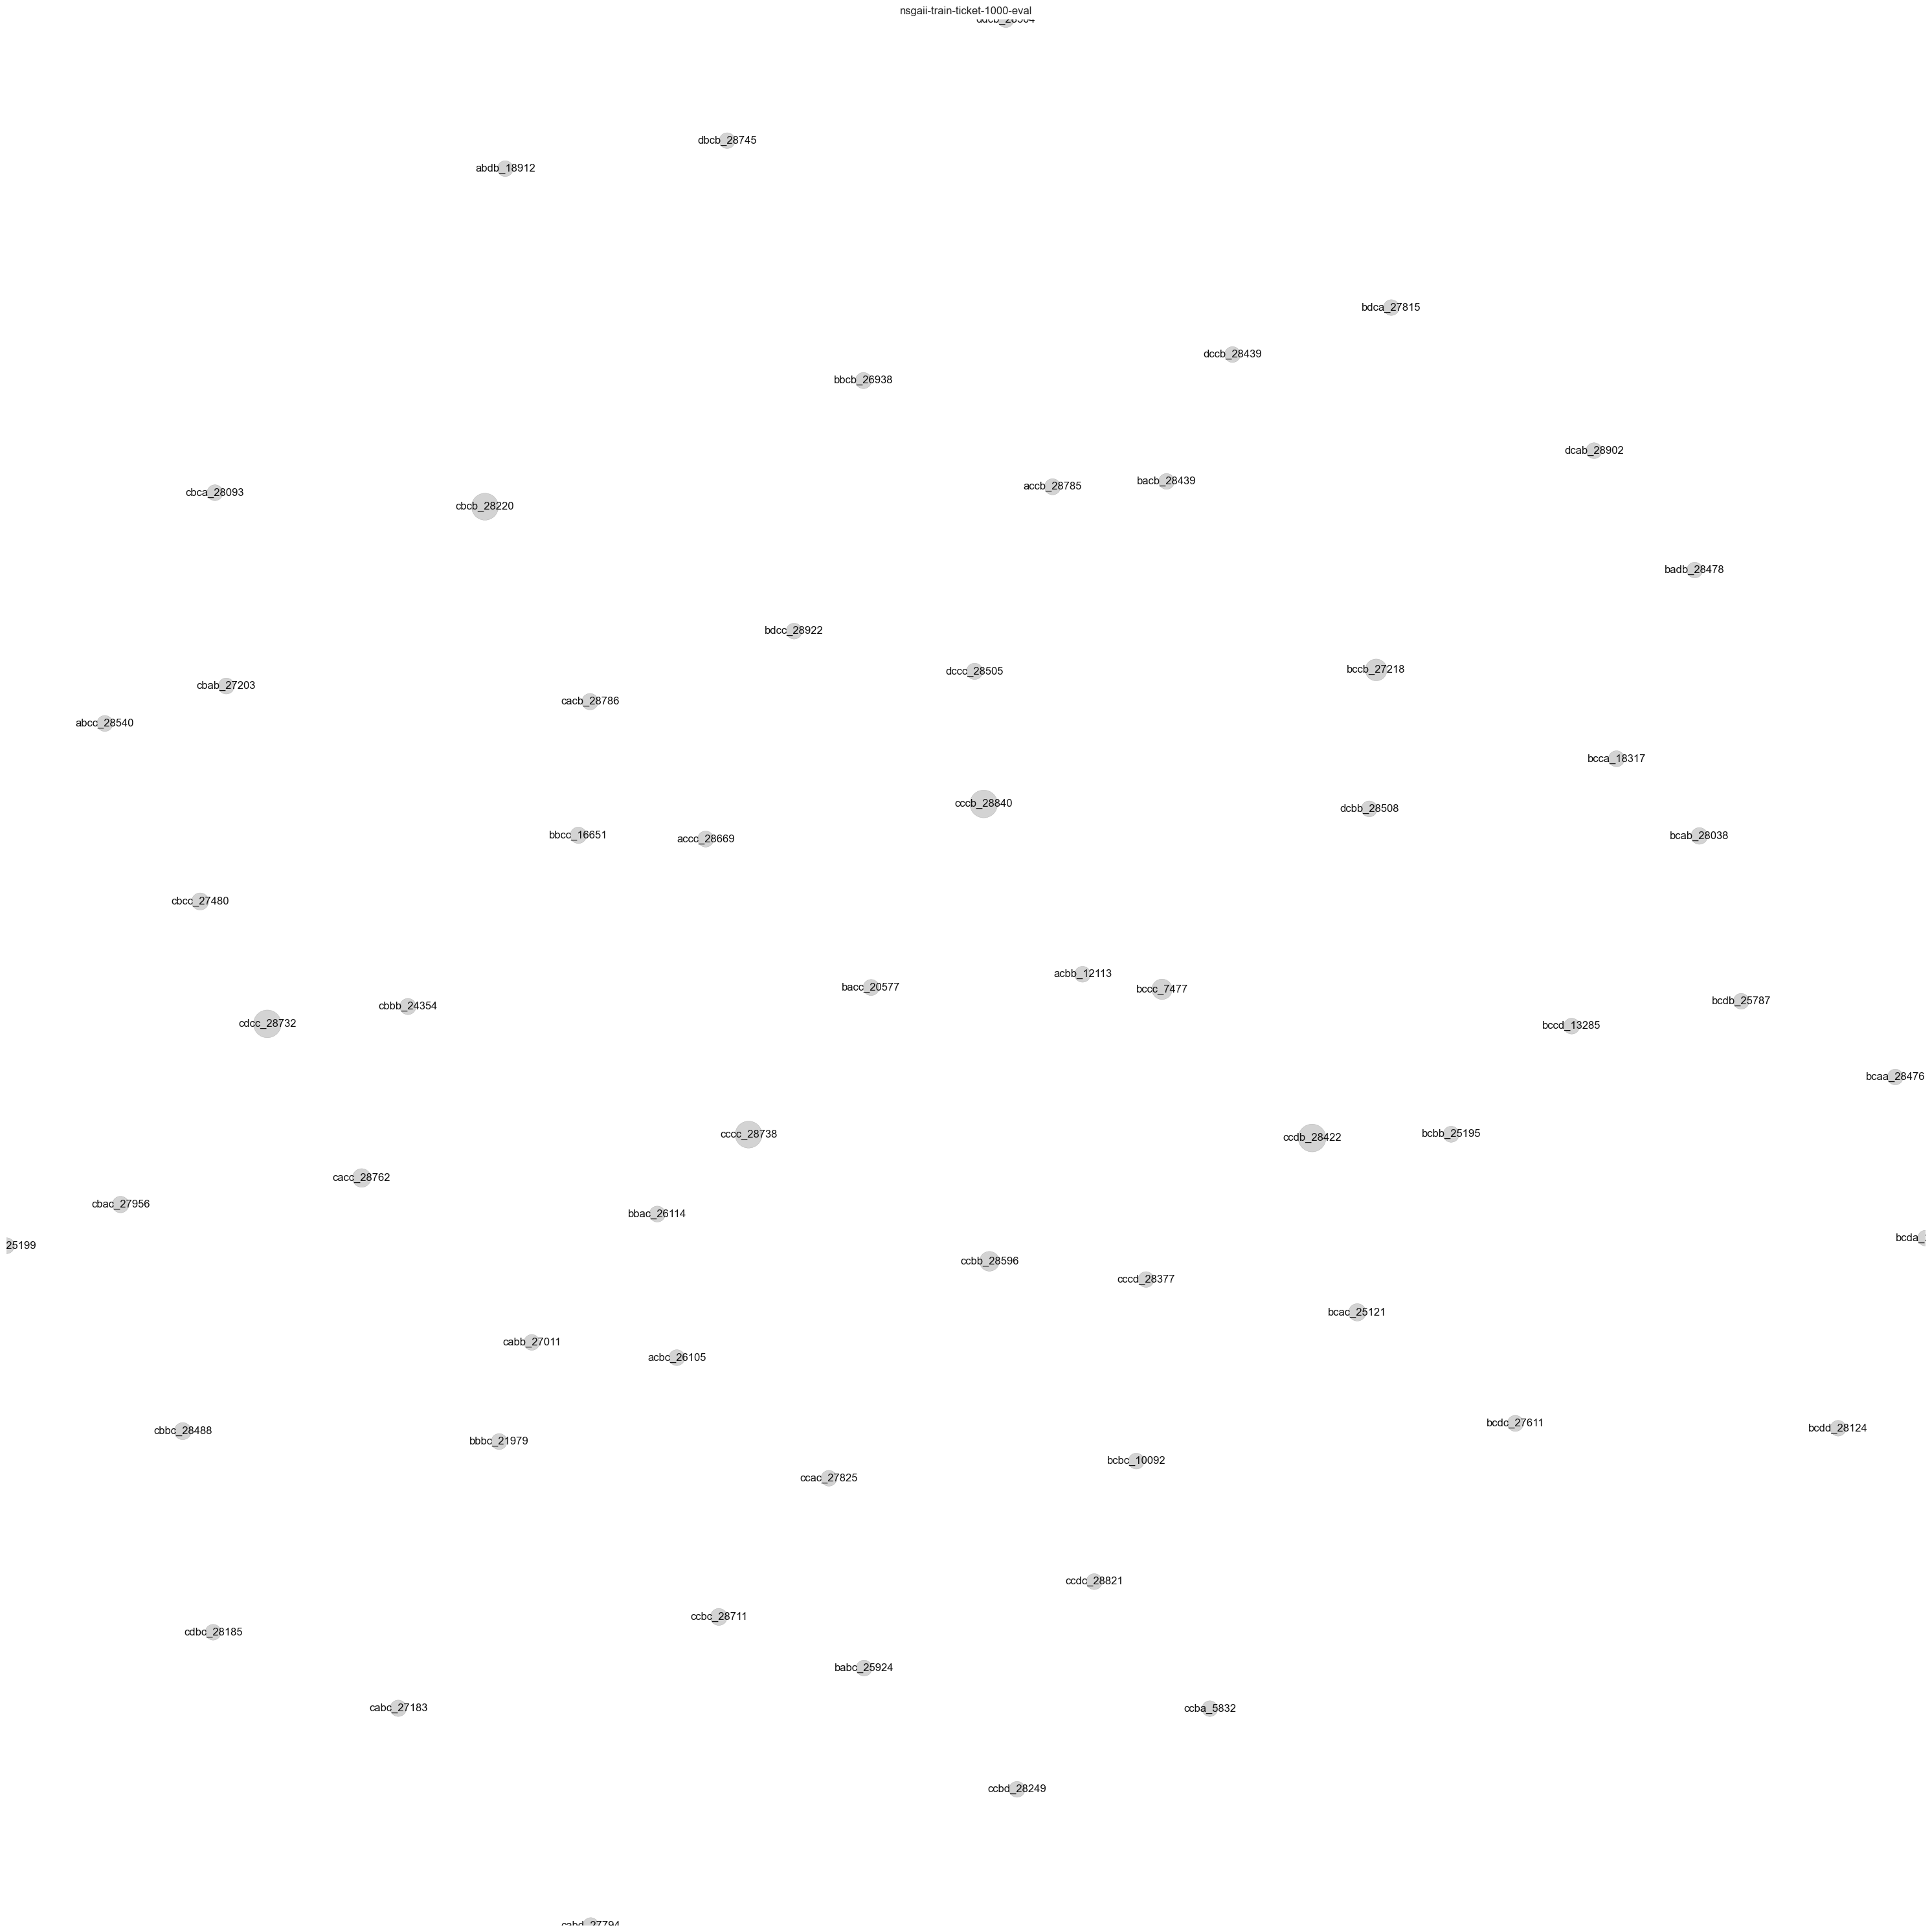

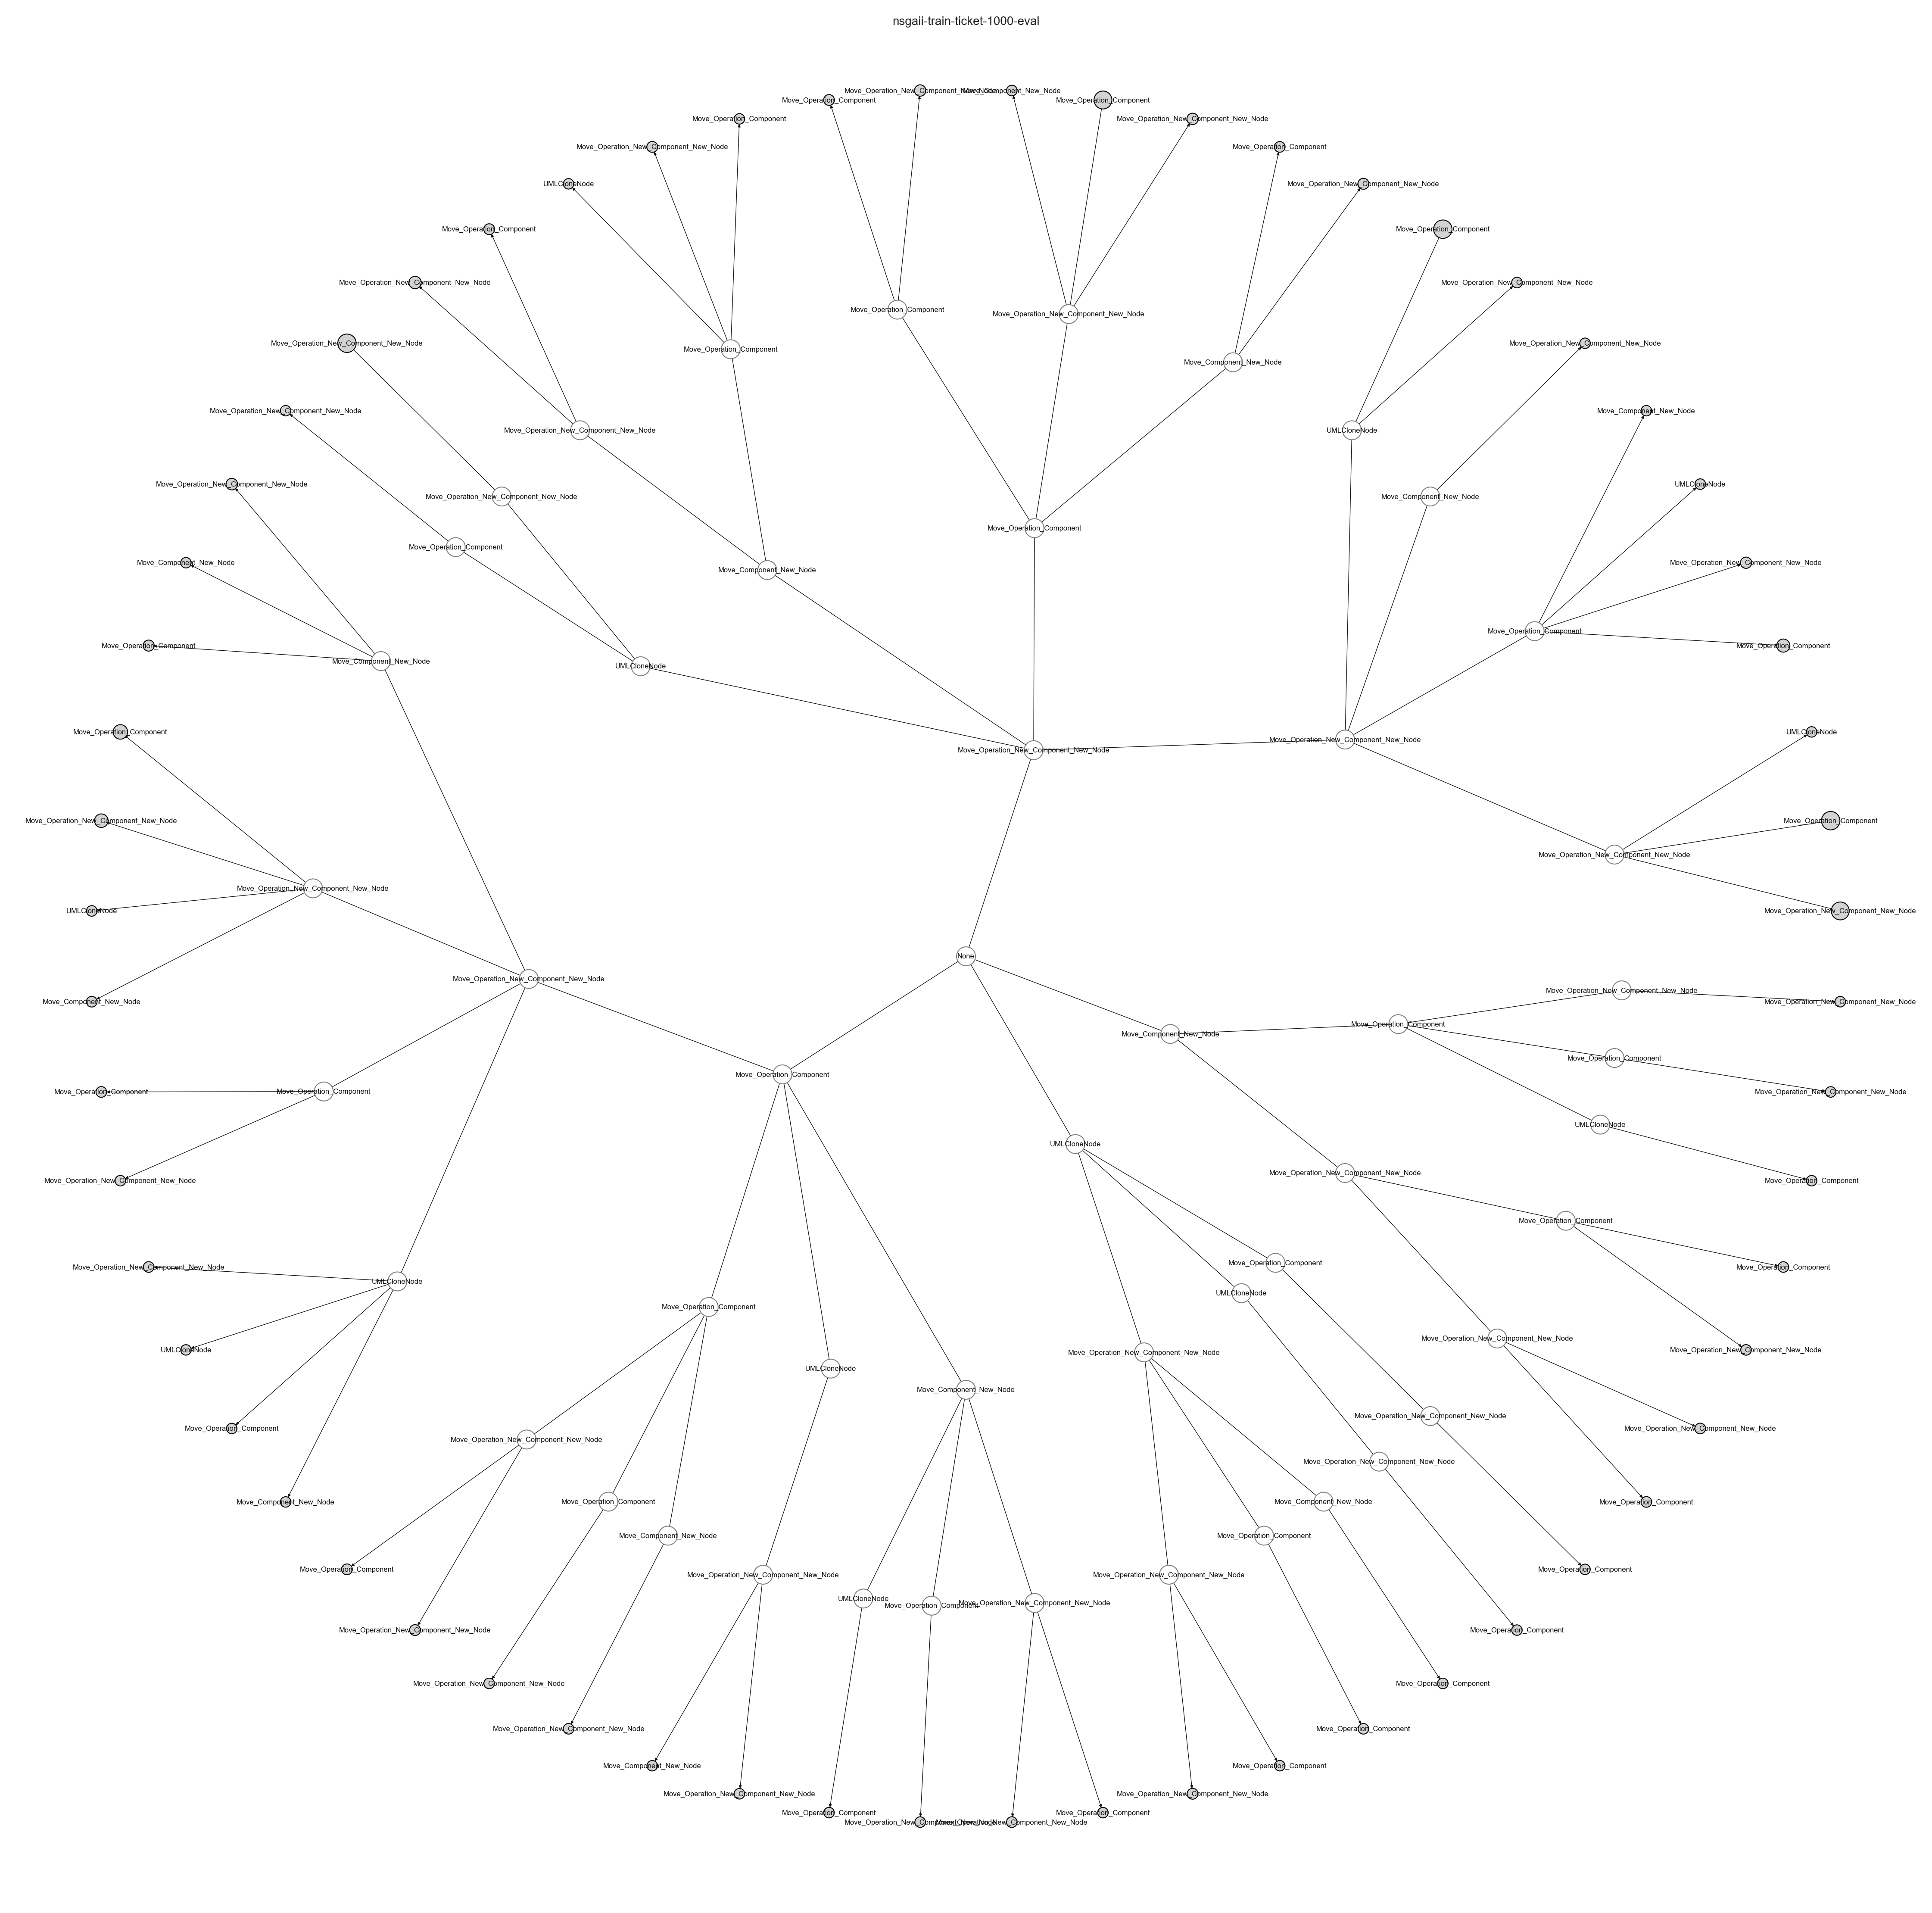

In [439]:
_ = ref1000_space.get_sequence_graph(unique_codes_ref1000, size=(30,30), show=True, info=None, metric='hamming') #metric='damerauLevenshtein') 
ref1000_trie = ref1000_space.get_prefix_tree(unique_codes_ref1000, size=(45,45), prog='twopi', info=None, encoder=global_le)
#ref1000_space.describe_cluster_labels()

In [440]:
nx.drawing.nx_pydot.write_dot(ref1000_trie, './datasets/it0_1000_baseline_trie.dot')

### *Codes and trees for Iteration 1 - Centroid 258*

In [441]:
codes, encoder = it1_50_c258_space.get_codes(use_alphabet=True, encoder=global_le)
unique_codes_centroid258 = dict(codes) # Note that duplicate codes are discarded (only one of the duplicates is kept)

refactions: 496
all operations: 1984
4 Distinct (individual) refactoring actions: {'Move_Component_New_Node', 'Move_Operation_New_Component_New_Node', 'Move_Operation_Component', 'UMLCloneNode'}
encoding refactions: 496
Sequence codes: 496 [('bbcc', 207), ('bbbb', 577), ('bbcc', 653), ('bbbb', 981), ('bbbb', 1330), ('bbcb', 1338), ('bbbc', 1371), ('bbbc', 1192), ('bbcc', 90), ('bbcc', 1240), ('bbcc', 1419), ('bbcc', 94), ('bbcc', 1431), ('bbbc', 1410), ('bbcc', 170), ('bbcb', 1322), ('bbbc', 143), ('bbcb', 166), ('bbcc', 557), ('bbbb', 818), ('bbbb', 1335), ('bbbb', 1224), ('bbbc', 1393), ('bbbc', 1358), ('bbcc', 1392), ('bbbb', 1086), ('bbcc', 106), ('bbbb', 1338), ('bbbb', 1427), ('bbcc', 1074), ('bbcc', 707), ('bbbb', 1430), ('bbcc', 84), ('bbcc', 116), ('bbbc', 572), ('bbbb', 1045), ('bbbb', 1341), ('bbcc', 1367), ('bbbb', 1113), ('bbbc', 1063), ('bbcc', 454), ('bbcc', 1394), ('bbcc', 444), ('bbcc', 1215), ('bbbb', 1156), ('bbbc', 1403), ('bbcc', 13), ('bbbc', 1316), ('bbcb', 12), 

hamming


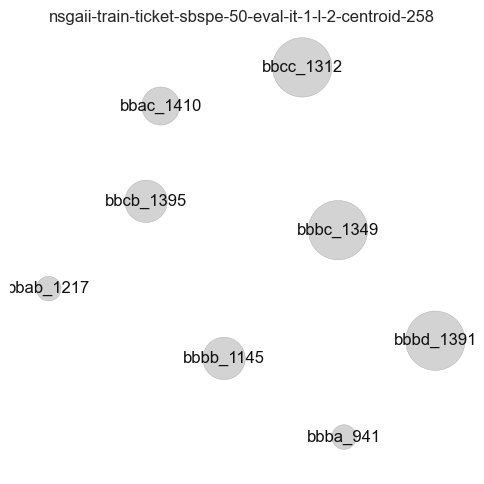

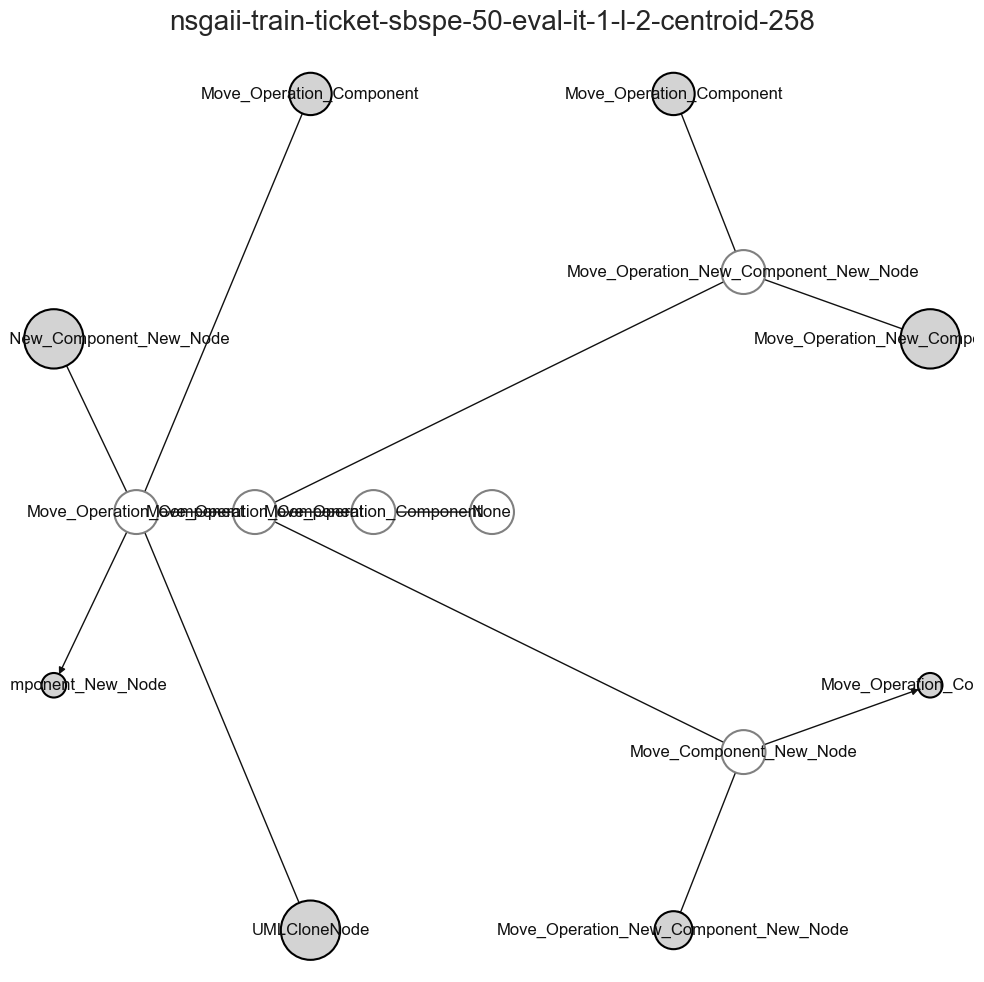

In [442]:
_ = it1_50_c258_space.get_sequence_graph(unique_codes_centroid258, size=(5,5), show=True, info=None, metric='hamming', margin=0.1) #, metric='damerauLevenshtein') 
it1_50_c258_trie = it1_50_c258_space.get_prefix_tree(unique_codes_centroid258, size=(10,10), prog='twopi', info=None, encoder=global_le)
#it1_50_c258_space.describe_cluster_labels()

In [443]:
nx.drawing.nx_pydot.write_dot(it1_50_c258_trie, './datasets/it1_50_c258_trie.dot')

### *Codes and trees for Iteration 1 - Centroid 223*

In [444]:
codes, encoder = it1_50_c223_space.get_codes(use_alphabet=True, encoder=global_le)
unique_codes_centroid223 = dict(codes) # Note that duplicate codes are discarded (only one of the duplicates is kept)

refactions: 496
all operations: 1984
4 Distinct (individual) refactoring actions: {'Move_Component_New_Node', 'Move_Operation_New_Component_New_Node', 'Move_Operation_Component', 'UMLCloneNode'}
encoding refactions: 496
Sequence codes: 496 [('ccba', 609), ('ccbc', 804), ('ccbb', 1370), ('ccbc', 1402), ('ccbb', 1179), ('ccab', 1117), ('cccc', 963), ('cccb', 1411), ('cccb', 780), ('cccb', 59), ('ccbc', 1253), ('cccc', 1425), ('ccbc', 441), ('ccbc', 1399), ('cccb', 1257), ('cccb', 1388), ('ccba', 75), ('cccc', 163), ('ccbc', 726), ('cccb', 772), ('ccbb', 1082), ('ccbb', 1144), ('cccb', 1321), ('ccbc', 1141), ('cccc', 1406), ('cccc', 582), ('ccba', 1255), ('ccbc', 419), ('ccbc', 1212), ('ccbc', 1218), ('cccb', 1402), ('ccbc', 1185), ('cccb', 72), ('cccc', 197), ('cccc', 262), ('cccb', 447), ('cccb', 1179), ('ccbb', 1331), ('ccbb', 946), ('cccb', 1394), ('ccbc', 1416), ('cccc', 1386), ('ccbb', 1141), ('ccbc', 1186), ('ccbc', 1375), ('cccc', 1371), ('cccb', 1264), ('cccb', 1325), ('ccab', 45

hamming


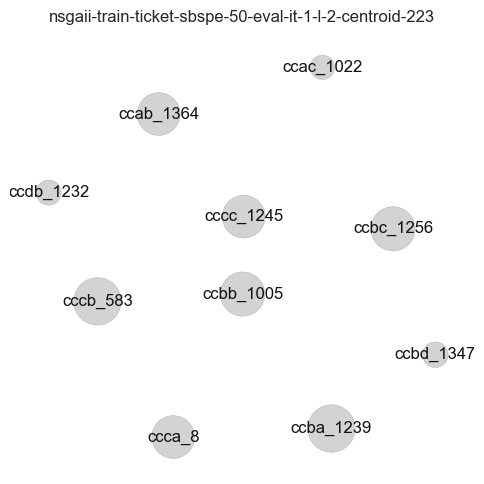

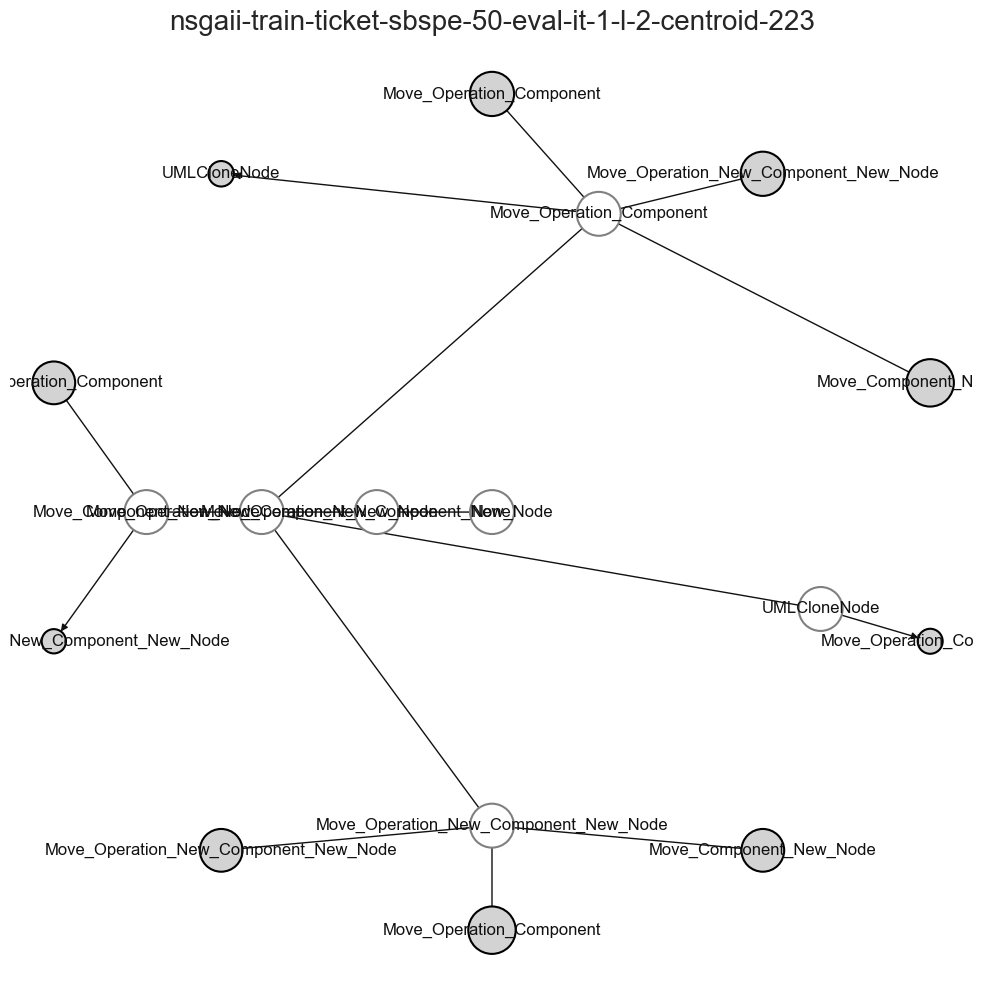

In [445]:
_ = it1_50_c223_space.get_sequence_graph(unique_codes_centroid223, size=(5,5), show=True, info=None, metric='hamming', margin=0.1) #, metric='damerauLevenshtein') 
it1_50_c223_trie = it1_50_c223_space.get_prefix_tree(unique_codes_centroid223, size=(10,10), prog='twopi', info=None, encoder=global_le)
#it1_50_c223_space.describe_cluster_labels()

In [446]:
nx.drawing.nx_pydot.write_dot(it1_50_c223_trie, './datasets/it1_50_c223_trie.dot')

### *Codes and trees for Iteration 0 - No interaction*

In [447]:
codes, encoder = it0_100_space.get_codes(use_alphabet=True, encoder=global_le)
unique_codes_ref100 = dict(codes) # Note that duplicate codes are discarded (only one of the duplicates is kept)

refactions: 495
all operations: 1980
4 Distinct (individual) refactoring actions: {'Move_Component_New_Node', 'Move_Operation_New_Component_New_Node', 'Move_Operation_Component', 'UMLCloneNode'}
encoding refactions: 495
Sequence codes: 495 [('cccc', 289), ('cbcb', 1221), ('cacc', 1265), ('cccc', 1459), ('cccb', 2081), ('ccca', 2740), ('cbab', 2857), ('accb', 2764), ('cbac', 1368), ('acbb', 520), ('cacc', 2772), ('cbac', 2434), ('acbc', 2682), ('cccb', 1220), ('cccc', 2102), ('cccb', 2679), ('bccb', 216), ('cccb', 652), ('cccb', 669), ('cccc', 1256), ('cccb', 2819), ('cccb', 2860), ('ccbb', 2861), ('cccc', 2243), ('bccb', 1956), ('cccc', 753), ('cbcc', 804), ('bccb', 1550), ('cccc', 2853), ('cccc', 2672), ('cccc', 2547), ('cccc', 1668), ('bacc', 828), ('cccb', 880), ('bccc', 1532), ('cccc', 1704), ('cbac', 1885), ('cccc', 2545), ('accc', 2667), ('acbc', 474), ('bacc', 2482), ('bccb', 1503), ('cccc', 2374), ('cccb', 2751), ('cccc', 2683), ('cccc', 2506), ('cccc', 2507), ('cccc', 2711), (

hamming


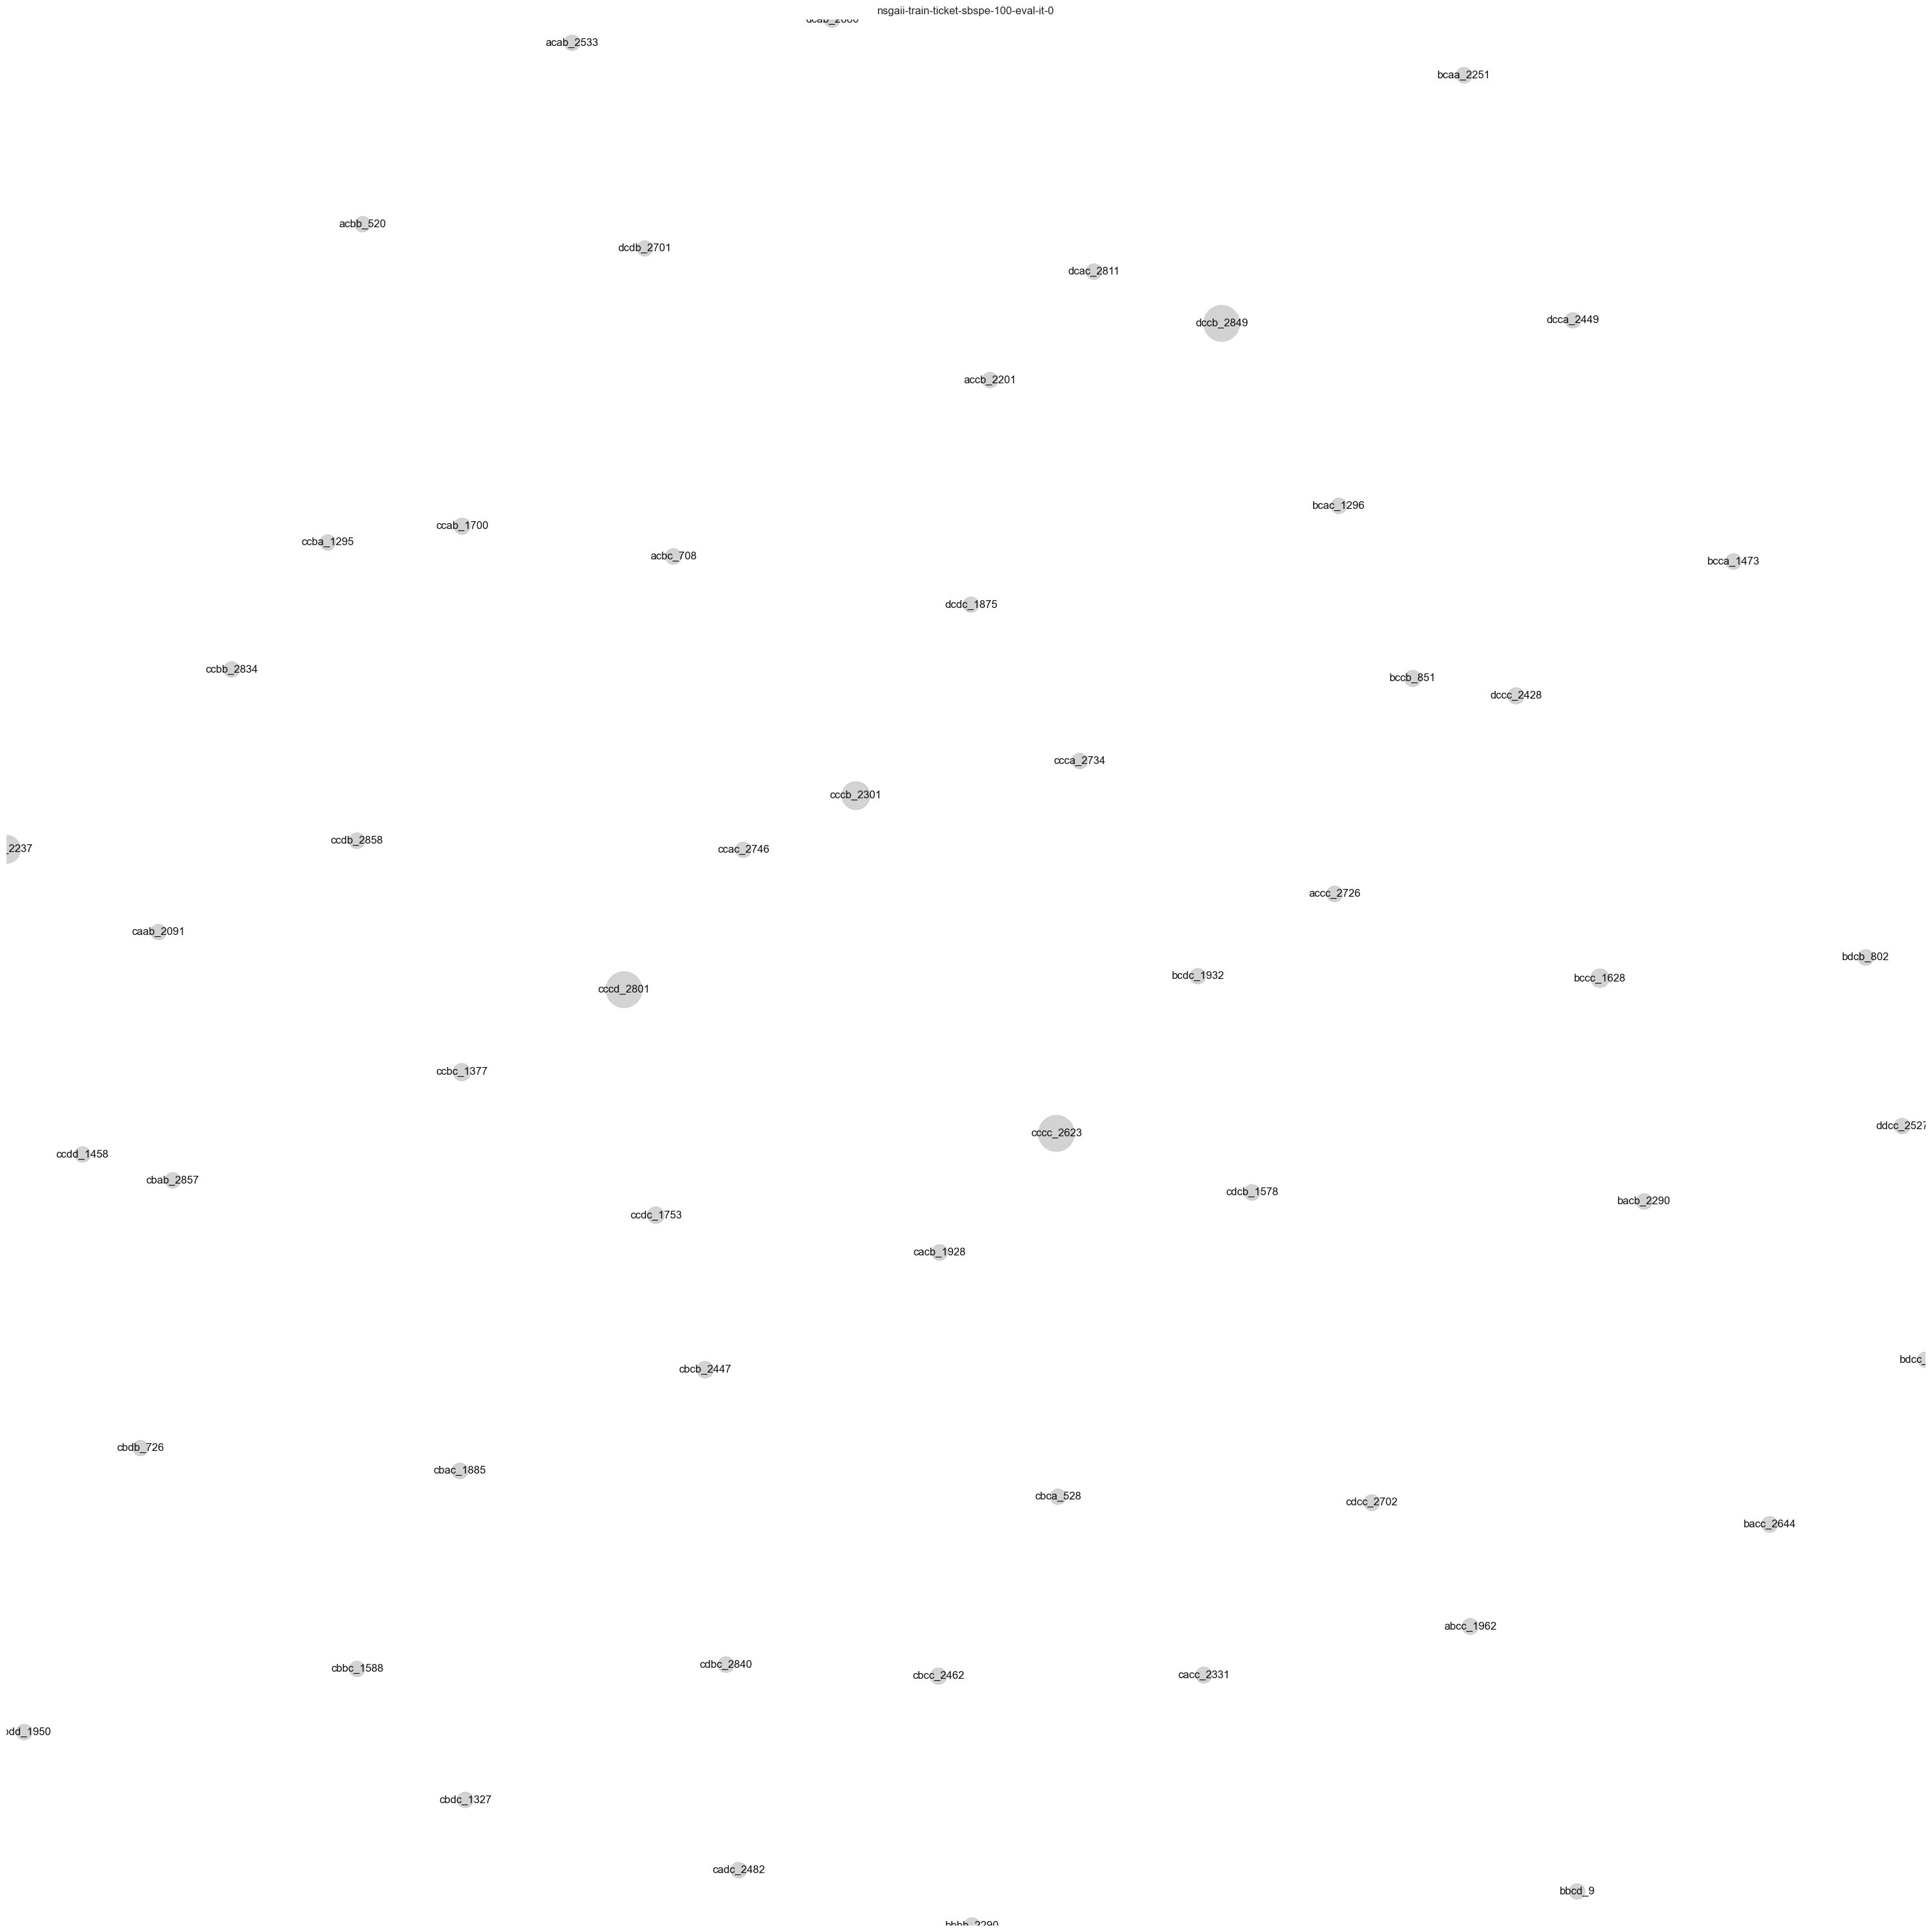

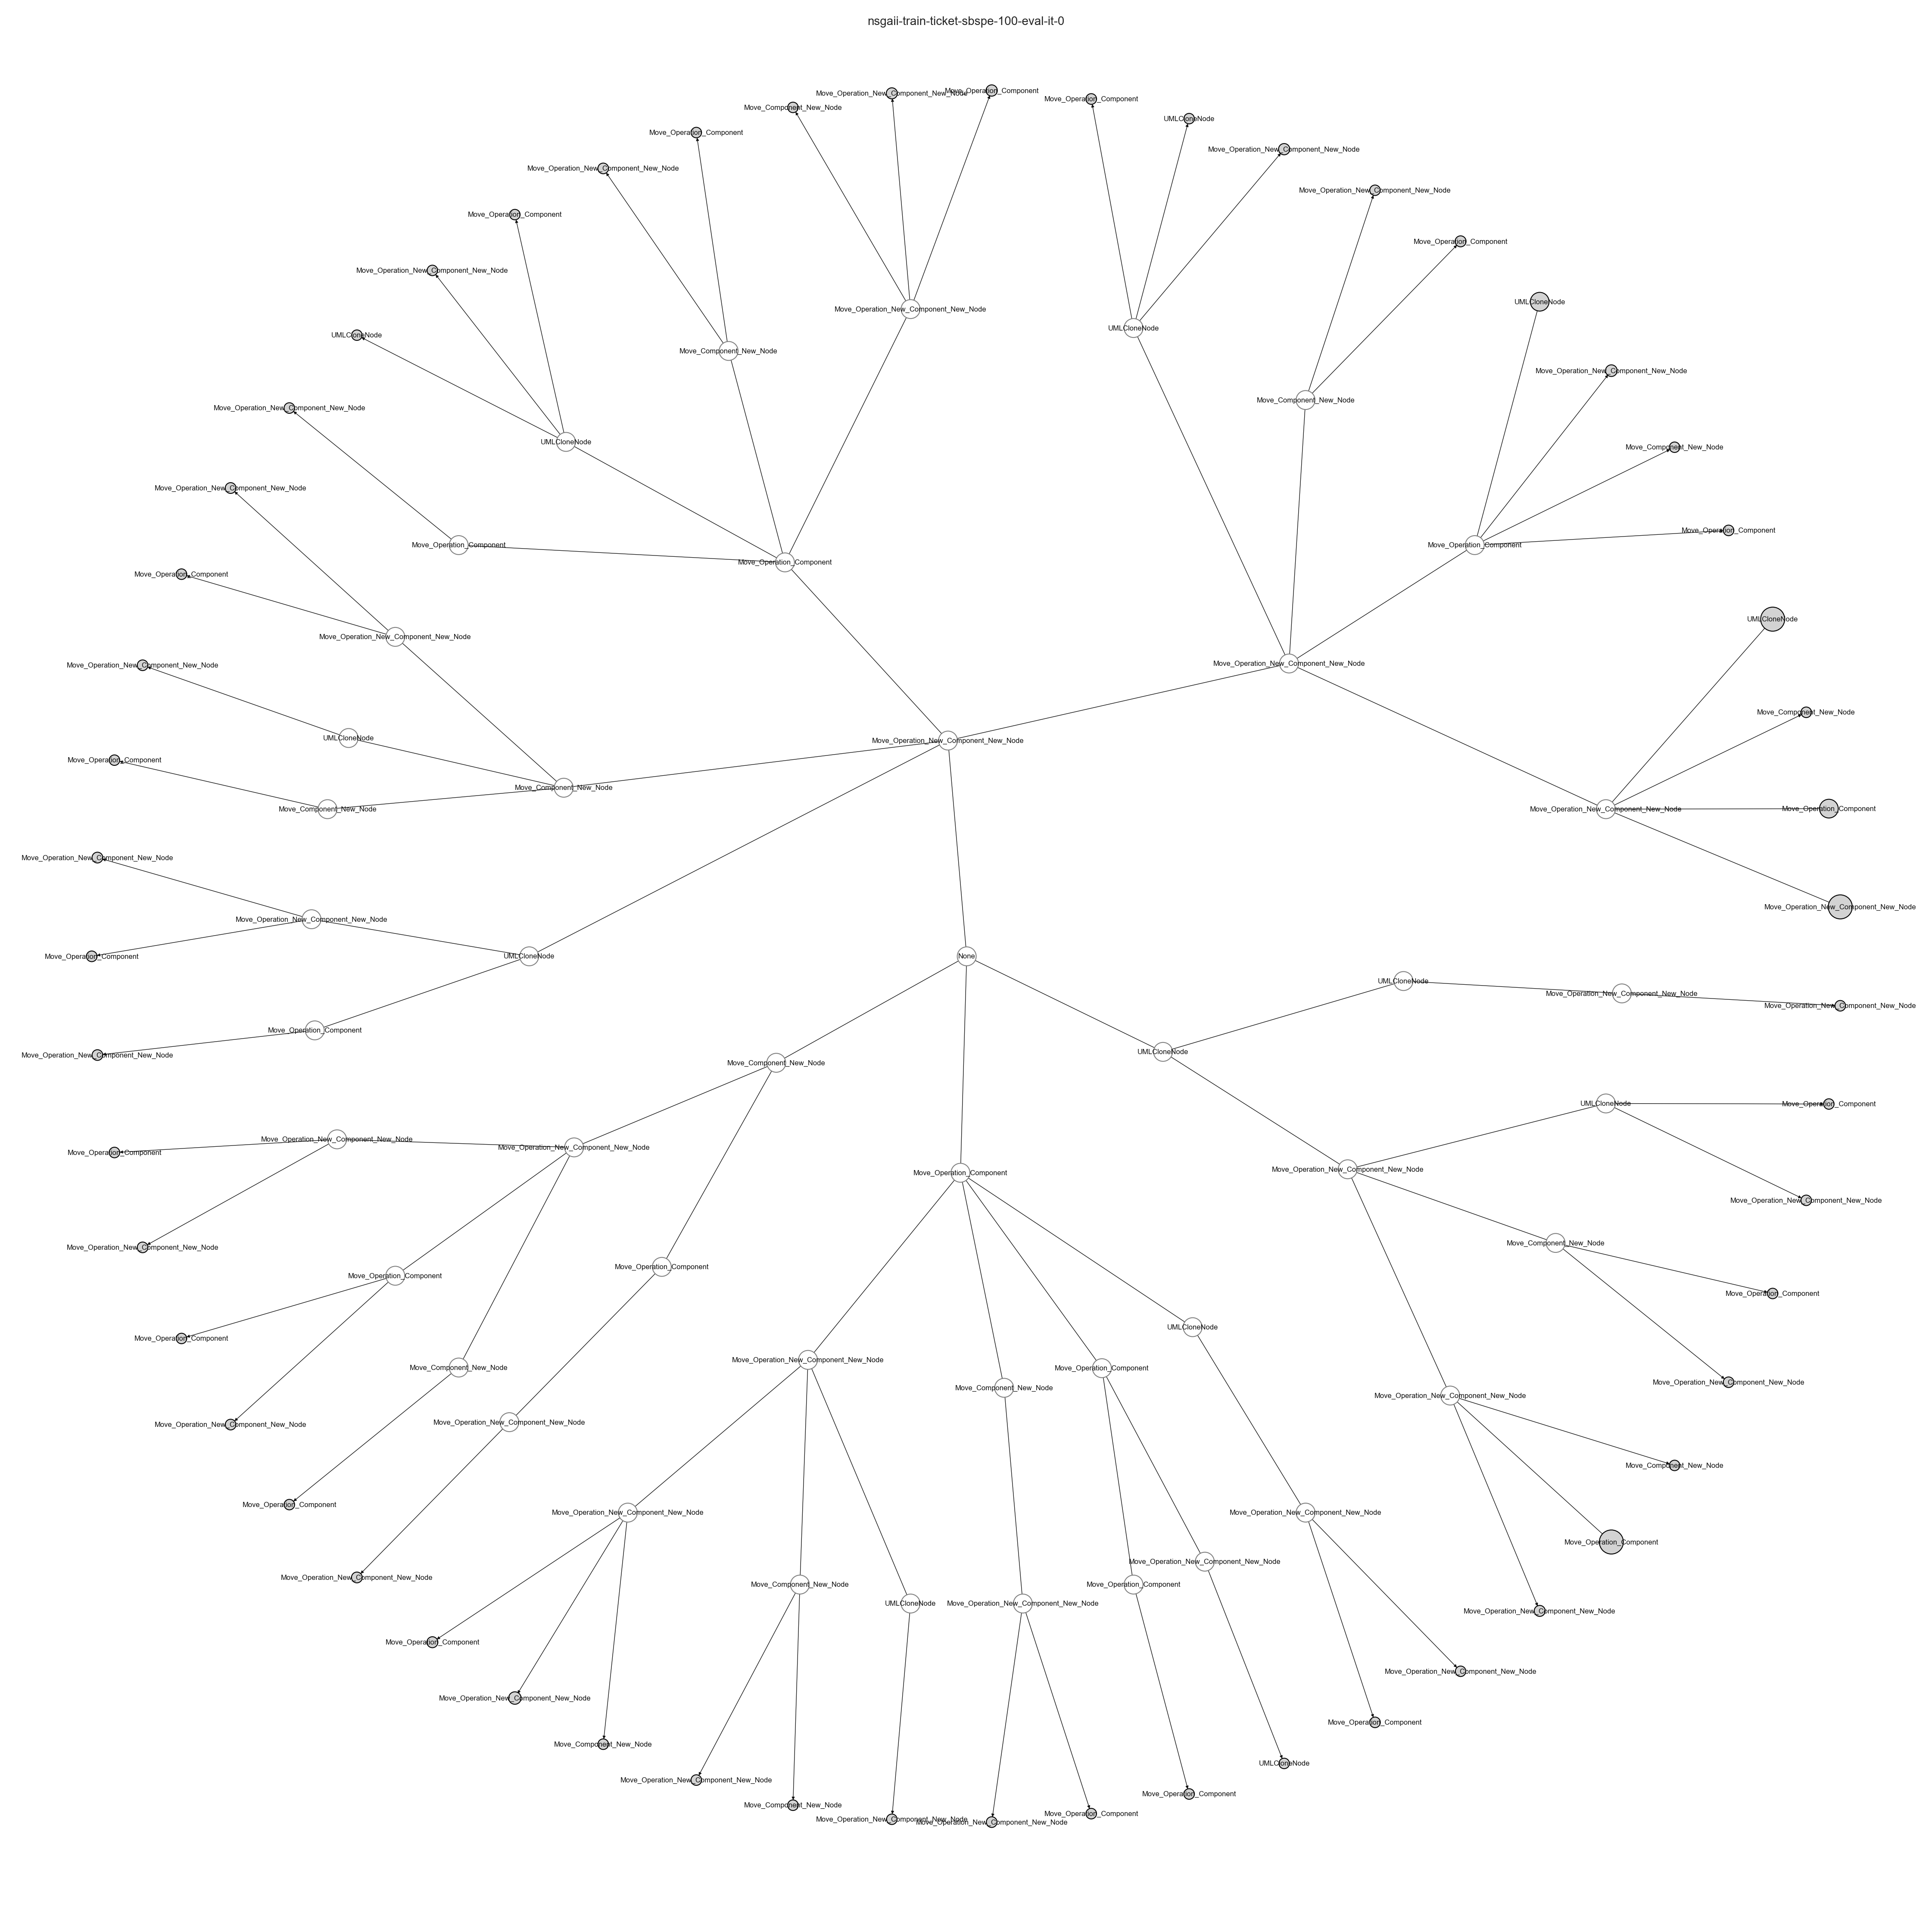

In [448]:
_ = it0_100_space.get_sequence_graph(unique_codes_ref100, size=(30,30), show=True, info=None, metric='hamming') #, metric='damerauLevenshtein') 
ref100_trie = it0_100_space.get_prefix_tree(unique_codes_ref100, size=(45,45), prog='twopi', info=None, encoder=global_le)
#it0_100_space.describe_cluster_labels()

In [449]:
nx.drawing.nx_pydot.write_dot(ref100_trie, './datasets/it0_100_baseline_trie.dot')

### *Computing tree distances*

In [450]:
# Garbage Collector - use it like gc.collect()
#import gc
#gc.collect()

In [451]:
print("Trie size for reference (1000):", ref1000_trie.number_of_nodes())
print("Trie size for centroid-258 (50):", it1_50_c258_trie.number_of_nodes())
print("Trie size for centroid-223 (50):", it1_50_c223_trie.number_of_nodes())
print("Trie size for reference (100):", ref100_trie.number_of_nodes())

Trie size for reference (1000): 110
Trie size for centroid-258 (50): 14
Trie size for centroid-223 (50): 17
Trie size for reference (100): 100


In [452]:
print('===== Trie for Reference (1000)')
print("\tcentroid-258", ArchitectureSpaceAnalyzer.compute_zss_distance_for_tries(ref1000_trie, it1_50_c258_trie))
print("\tcentroid-223", ArchitectureSpaceAnalyzer.compute_zss_distance_for_tries(ref1000_trie, it1_50_c223_trie))
print("\treference-100", ArchitectureSpaceAnalyzer.compute_zss_distance_for_tries(ref1000_trie, ref100_trie))

===== Trie for Reference (1000)
root: 0 <class 'str'>
root: 0 <class 'str'>
	centroid-258 102.0
root: 0 <class 'str'>
root: 0 <class 'str'>
	centroid-223 102.0
root: 0 <class 'str'>
root: 0 <class 'str'>
	reference-100 104.0


In [453]:
print('===== Trie for Reference (100)')
print("\tcentroid-258", ArchitectureSpaceAnalyzer.compute_zss_distance_for_tries(ref100_trie, it1_50_c258_trie))
print("\tcentroid-223", ArchitectureSpaceAnalyzer.compute_zss_distance_for_tries(ref100_trie, it1_50_c223_trie))

===== Trie for Reference (100)
root: 0 <class 'str'>
root: 0 <class 'str'>
	centroid-258 94.0
root: 0 <class 'str'>
root: 0 <class 'str'>
	centroid-223 90.0


In [454]:
print('===== centroid-258 versus centroid-223')
print("\t", ArchitectureSpaceAnalyzer.compute_zss_distance_for_tries(it1_50_c258_trie, it1_50_c223_trie))

===== centroid-258 versus centroid-223
root: 0 <class 'str'>
root: 0 <class 'str'>
	 8.0


## **Comparison of sequences (types)**

In [455]:
sequences_ref1000 = set(unique_codes_ref1000.keys())
sequences_centroid258 = set(unique_codes_centroid258.keys())
sequences_centroid223 = set(unique_codes_centroid223.keys())
sequences_ref100 = set(unique_codes_ref100.keys())

Union of solutions: 18


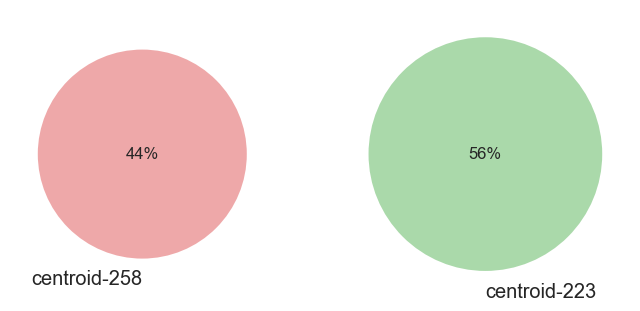

In [456]:
fig = plt.figure(figsize=(8,8))
plot2([sequences_centroid258, sequences_centroid223], ['centroid-258', 'centroid-223'])
plt.show()

Union of solutions: 78


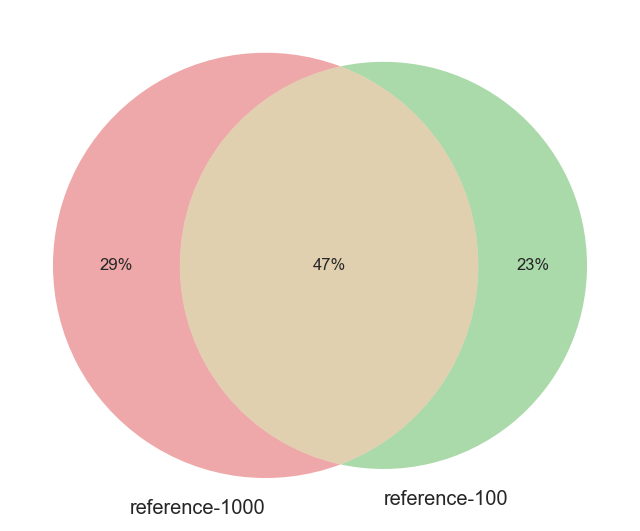

In [457]:
fig = plt.figure(figsize=(8,8))
plot2([sequences_ref1000, sequences_ref100], ['reference-1000', 'reference-100'])
plt.show()

Union of solutions: 62


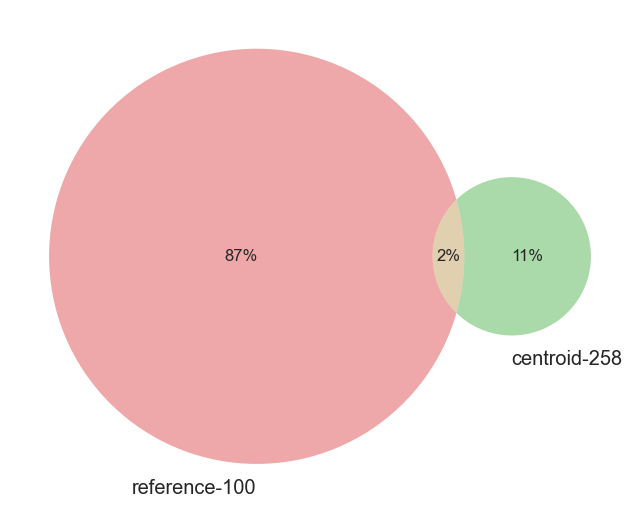

In [458]:
fig = plt.figure(figsize=(8,8))
plot2([sequences_ref100, sequences_centroid258], ['reference-100', 'centroid-258'])
plt.show()

Union of solutions: 55


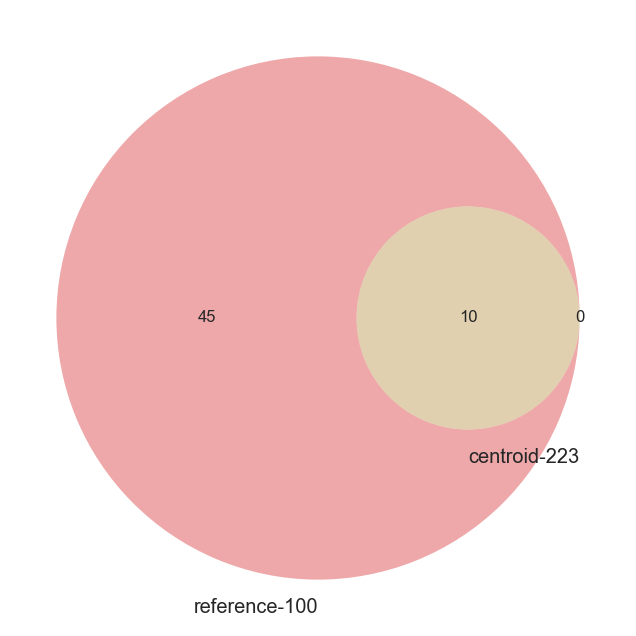

In [459]:
fig = plt.figure(figsize=(8,8))
plot2([sequences_ref100, sequences_centroid223], ['reference-100', 'centroid-223'], percentage=False)
plt.show()

Union of solutions: 62


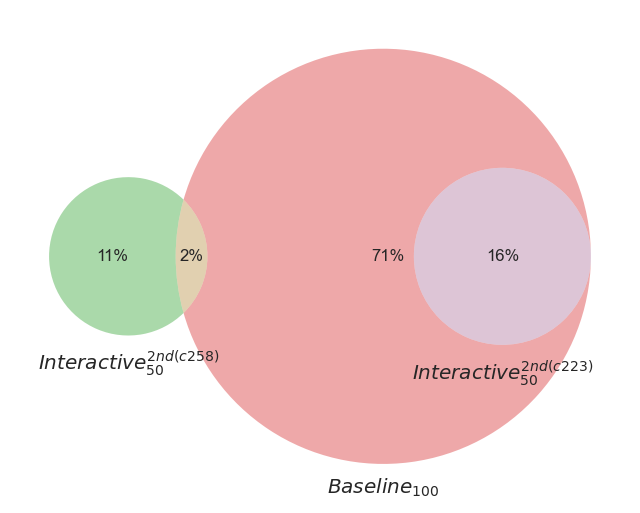

In [460]:
fig = plt.figure(figsize=(8,8))
plot3([sequences_ref100, sequences_centroid258, sequences_centroid223], ['$Baseline_{100}$','$Interactive_{50}^{2nd(c258)}$','$Interactive_{50}^{2nd(c223)}$'])
plt.show()

Union of solutions: 62
Union of solutions: 18
Union of solutions: 78


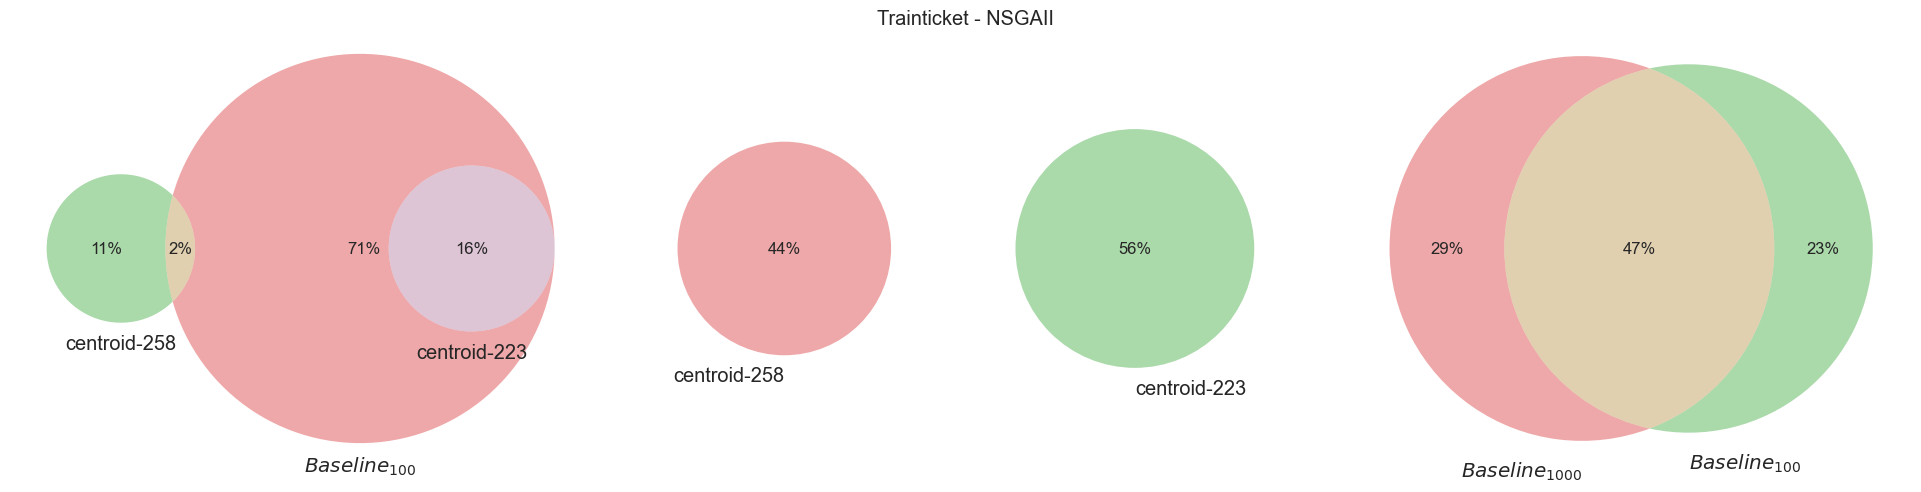

In [461]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
plot3([sequences_ref100, sequences_centroid258, sequences_centroid223], ['$Baseline_{100}$','centroid-258','centroid-223'], ax=axes[0])
plot2([sequences_centroid258, sequences_centroid223], ['centroid-258', 'centroid-223'], ax=axes[1])
plot2([sequences_ref1000, sequences_ref100], ['$Baseline_{1000}$', '$Baseline_{100}$'], ax=axes[2])
plt.tight_layout()
plt.suptitle('Trainticket - NSGAII')
plt.show()

---